<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/TestBench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
IN_COLAB = True

output_dir = 'results/'

try:
  import google.colab
  # Using Google Drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Dataset download and extraction
  !unzip -qq drive/MyDrive/cern/data/rich.zip

  # Model checkpoint download and extraction
  !unzip -qq drive/MyDrive/cern/data/checkpoints_dropout_0.01.zip

  # Model embeddings download and extraction
  !unzip -qq drive/MyDrive/cern/data/embeddings.zip

  # Results folder creation
  !mkdir /content/drive/MyDrive/cern/data/results

  output_dir = f'/content/drive/MyDrive/cern/data/{output_dir}'

except:
  IN_COLAB = False

print(f'IN_COLAB: {IN_COLAB}')

Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/MyDrive/cern/data/results’: File exists
IN_COLAB: True


In [2]:
!git clone https://github.com/evillag/uncertainty_gan.git
!mv uncertainty_gan/mcd .
!mv uncertainty_gan/feature_densities .
!mv uncertainty_gan/test_bench .
%rm -rf uncertainty_gan/

!git clone https://gitlab.com/lambda-hse/lhcb-rich-gan-uncertainty.git
!mv lhcb-rich-gan-uncertainty/experiments .
!mv lhcb-rich-gan-uncertainty/src .
%rm -rf lhcb-rich-gan-uncertainty/
%rm -rf sample_data/
%pip install tensorflow-addons

Cloning into 'uncertainty_gan'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 186 (delta 18), reused 4 (delta 3), pack-reused 147
Receiving objects: 100% (186/186), 22.63 MiB | 18.81 MiB/s, done.
Resolving deltas: 100% (94/94), done.
Cloning into 'lhcb-rich-gan-uncertainty'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210 (from 1)
Receiving objects: 100% (210/210), 2.94 MiB | 28.15 MiB/s, done.
Resolving deltas: 100% (94/94), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.5 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import numpy as np

from test_bench import get_checkpoint_name, load_particle_datasets, subsample_dataset
from test_bench.model import MonteCarloDropoutModel

# Test Bench for the Monte Carlo Dropout and Feature Density methods

1. Select sample data
2. Create a model
3. Generate a single target with single inference mode
4. Estimate MCD uncertainty
5. Estimate FD uncertainty

In [4]:
# Parameters
PARTICLE = 'pion'
CHECKPOINT_DP = 0.01
DROPOUT_TYPE = 'bernoulli_structured'
CHECKPOINT_BASE = 'checkpoints/'
DATA_DIR = 'rich/'
SUB_SAMPLE_SIZE = 100000
DLL_COLUMNS = ['RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']

# MCD parameters
MCD_ENSEMBLE_SIZE = 300

# FD parameters
embeddings_dir = f'embeddings/'

# Load results (Optional)

Uncomment to load previous execution results.

In [8]:
# x_sample = np.load(output_dir + f'{PARTICLE}_x_real.npy')
# y_sample = np.load(output_dir + f'{PARTICLE}_y_real.npy')
# t_generated = np.load(output_dir + f'{PARTICLE}_t_generated.npy')

# mcd_uncertainty = np.load(output_dir + f'{PARTICLE}_mcd_uncertainty.npy')
# fd_uncertainty_normalized = np.load(output_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy')
# fd_uncertainty_integration = np.load(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy')

# Load data and Sample selection

In [15]:
dataset = load_particle_datasets(PARTICLE, DATA_DIR)

Reading and concatenating datasets:
	rich/pion2_-_down_2016_.csv
	rich/pion_+_down_2016_.csv
	rich/pion2_-_up_2016_.csv
	rich/pion2_+_up_2016_.csv
	rich/pion_-_up_2016_.csv
	rich/pion_-_down_2016_.csv
	rich/pion2_+_down_2016_.csv
	rich/pion_+_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 1.842810869216919
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>
feats_train shape	(948292, 3)
targets_train shape	(948292, 5)
feats_val shape  	(525967, 3)
targets_val shape	(525967, 5)



In [16]:
# Draw a sample of the datasets
x_sample, y_sample = subsample_dataset(dataset['feats_val'], dataset['targets_val'], SUB_SAMPLE_SIZE / dataset['feats_val'].shape[0])
x_sample.shape, y_sample.shape

(TensorShape([100000, 3]), TensorShape([100000, 5]))

# Model creation

In [17]:
model = MonteCarloDropoutModel(
    PARTICLE,
    dropout_rate=CHECKPOINT_DP,
    checkpoint_dir=CHECKPOINT_BASE + get_checkpoint_name(PARTICLE, CHECKPOINT_DP, DROPOUT_TYPE),
    debug=True
)
generator = model.get_generator()

Generating model for pion with a dropout rate of 0.01
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4

Generator:

Model: "virtual_ensemble_model"
________________________________________________________________________________________________
 Layer (type)                              Output Shape                          Param #        
 Inputs (InputLayer)                       [(None, 3)]                           0              
                                                                                                
 NoiseInjection (NoiseInjection)           (None, 67)                            0              
                                                                                                
 Layer_0/Dense (Dense)                     (None, 128)                           8704           
                                                                                                
 Layer_0/LeakyReLU (LeakyReLU)             (None, 128)                           0   

## Single model prediction

In [18]:
generator.single_model_inference_mode()
t_generated = generator.predict(x_sample)
t_generated.shape

3125/3125 [==============================] - 13s 3ms/step


(100000, 5)

In [19]:
# Save real and generated targets
np.save(output_dir + f'{PARTICLE}_x_real.npy', x_sample)
np.save(output_dir + f'{PARTICLE}_y_real.npy', y_sample)
np.save(output_dir + f'{PARTICLE}_t_generated.npy', t_generated)

### Plotting functions

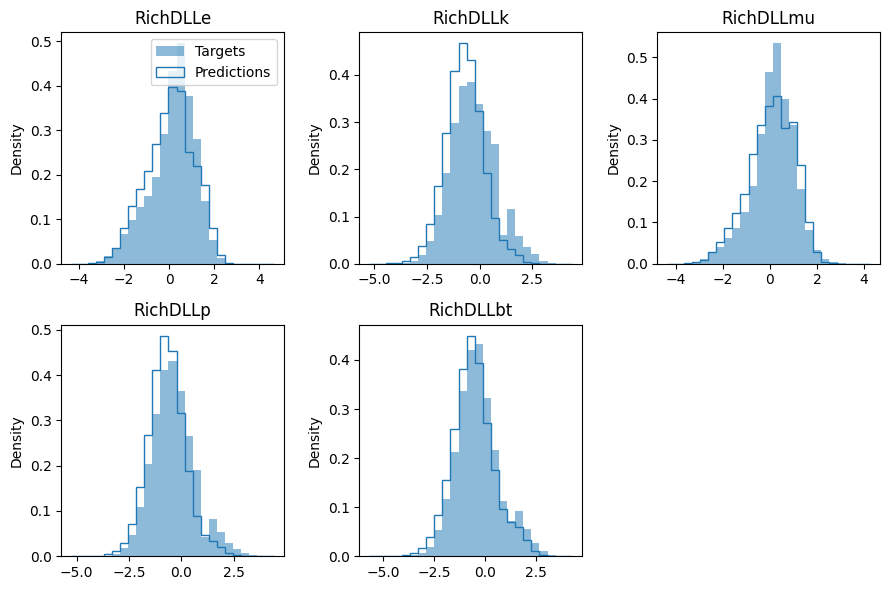

In [20]:
def plot_target_histrogams(real_targets, generated_targets, dll_columns=DLL_COLUMNS):
  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    particle_targets = np.array(real_targets[:, i])
    particle_predictions = np.array(generated_targets[:, i])

    mins = particle_targets.min(), particle_predictions.min()
    maxs = particle_targets.max(), particle_predictions.max()

    hist_range = min(mins), max(maxs)

    ax.set_title(dll_columns[i])
    ax.hist(particle_targets, 25, hist_range, True, alpha=.5, label='Targets')
    ax.hist(particle_predictions, 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')
    ax.set_ylabel('Density')

  axes[0, 0].legend()
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

plot_target_histrogams(y_sample, t_generated)

The problem with `estimate_distances_and_plot_uncertainty_bins` is that it splits the data in unbalnced bins, with different sizes, some bins could get up to 30k samples while others get less than 20. Instead binning by quantiles generates a balanced number of observations per bin.

In [155]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import linregress

def estimate_distances_and_plot_uncertainty_bins(y_real, y_generated, uncertainty_scores, uncertainty_type = None,
                                                 particle_index = 0, n_rows = 2, n_cols = 5, dll_columns=DLL_COLUMNS):

  n_bins = n_rows * n_cols

  targets = np.array(y_real[:, particle_index])
  predictions = np.array(y_generated[:, particle_index])
  uncertainty_scores = np.array(uncertainty_scores)

  if uncertainty_type == 'MCD':
    uncertainty_scores = uncertainty_scores[:, particle_index]

  bin_edges = np.linspace(uncertainty_scores.min(), uncertainty_scores.max(), n_bins + 1)

  # Digitize returns sample indices per bin
  bin_indices = np.digitize(uncertainty_scores, bin_edges)

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

  rounded_bin_edges = np.round(bin_edges, 2)

  js_distances = []

  for i, ax in enumerate(axes.flatten()):
    indices = bin_indices == i + 1

    mins = targets[indices].min(), predictions[indices].min()
    maxs = targets[indices].max(), predictions[indices].max()

    hist_range = min(mins), max(maxs)

    targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
    predictions_hist = ax.hist(
        predictions[indices], 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')[0]

    ax.set_xlabel(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}', bbox={'facecolor': 'none'})

    js_dist = jensenshannon(predictions_hist, targets_hist)
    js_distances += [js_dist]
    print(f'{rounded_bin_edges[i]:.2f} < unc. score < {rounded_bin_edges[i + 1]:.2f}: Number of observations: {len(predictions[indices])}')

  plt.suptitle(f'{uncertainty_type} uncertainty score bins for {dll_columns[particle_index]}')
  axes[0, 0].legend()
  plt.tight_layout()
  plt.show()
  print("Jensen–Shannon distances:\n" + ", ".join([str(dist) for dist in js_distances]))

  return bin_edges, js_distances


def plot_distances(bin_ranges, distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0):
  plt.title(f'{uncertainty_type} reliability curve for {dll_columns[particle_index]}')
  plt.gca().set_axisbelow(True)
  plt.grid()
  plt.plot(bin_ranges[:-1], distances, '.-')
  plt.xlabel('Uncertainty score')
  plt.ylabel('Jensen–Shannon distance')
  plt.show()

  print('Correlation coefficient:', linregress(bin_ranges[:-1], distances).rvalue)

def plot_all_distances(all_bin_ranges, all_distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0):
  plt.title(f'{uncertainty_type} reliability curves')
  plt.gca().set_axisbelow(True)
  plt.grid()

  for i in range(5):
    plt.plot(all_bin_ranges[i][:-1], all_distances[i], '.-', label=dll_columns[i])
    regress = linregress(all_bin_ranges[i][:-1], all_distances[i])
    print(f'Correlation coefficient for {dll_columns[i]}:', regress.rvalue)

  plt.xlabel('Uncertainty score')
  plt.ylabel('Jensen–Shannon distance')
  plt.legend()
  plt.show()

In [182]:
def jensenshannon_distance(targets, predictions):
    targets = np.array(targets)
    predictions = np.array(predictions)
    return jensenshannon(np.histogram(predictions)[0], np.histogram(targets)[0])

def get_quantile_bins(uncertainty, quantile=0.1):
  return np.quantile(uncertainty, np.arange(0.0, 1.01, quantile))


def estimate_distances_per_quantiles(y_real, y_generated, uncertainty, uncertainty_type = 'MCD', particle_index = 0,
                                     quantile=0.1):
  """
  Estimates distances per bins based on consecutive quantiles.

  Args:
    targets: A NumPy array containing target values.
    predictions: A NumPy array containing prediction values.
    uncertainty: A NumPy array containing uncertainty values.
  """
  targets = np.array(y_real[:, particle_index])
  predictions = np.array(y_generated[:, particle_index])
  uncertainty = np.array(uncertainty)

  if uncertainty_type == 'MCD':
    uncertainty = uncertainty[:, particle_index]

  bins = get_quantile_bins(uncertainty, quantile)
  distances = []
  # Get each bin instance
  for i, (bin_min, bin_max) in enumerate(zip(bins[:-1], bins[1:])):
    bin_mask = (uncertainty >= bin_min) & (uncertainty < bin_max)
    distances.append(jensenshannon_distance(predictions[bin_mask], targets[bin_mask]))
    print(f'{bin_min:.2f} < unc. score < {bin_max:.2f}: JS-Distance: {distances[-1]:.2f}' \
          f' Number of observations: {len(predictions[bin_mask])}')
  return bins, np.array(distances)


def plot_uncertainty_bins(y_real, y_generated, uncertainty, uncertainty_type = 'FD', particle_index = 0, quantile=0.1,
                          n_rows = 2, n_cols = 5, plt_histogram_bins= 25, dll_columns=DLL_COLUMNS):


  targets = np.array(y_real[:, particle_index])
  predictions = np.array(y_generated[:, particle_index])
  uncertainty = np.array(uncertainty)

  if uncertainty_type == 'MCD':
    uncertainty = uncertainty[:, particle_index]

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
  bins = get_quantile_bins(uncertainty, quantile)
  axes = axes.flatten()

  # Plot the uncertainty bins
  for i, (bin_min, bin_max) in enumerate(zip(bins[:-1], bins[1:])):
    bin_mask = (uncertainty >= bin_min) & (uncertainty < bin_max)
    ax = axes[i]
    ax.hist(targets[bin_mask], plt_histogram_bins, density=True, alpha=.5, label='Targets')
    ax.hist(predictions[bin_mask], plt_histogram_bins, density=True, histtype='step', color='tab:blue',
            label='Predictions')
    ax.set_xlabel(f'{bin_min:.2f} < unc. score < {bin_max:.2f}', bbox={'facecolor': 'none'})

  plt.suptitle(f'{uncertainty_type} uncertainty score bins for {dll_columns[particle_index]}')
  axes[0].legend()
  plt.tight_layout()
  plt.show()


## Monte Carlo Dropout method

In [25]:
from mcd.MCDEvaluator import evaluate_model as mcd_evaluate_model

mcd_uncertainty = mcd_evaluate_model(model, x_sample, MCD_ENSEMBLE_SIZE)[0]
mcd_uncertainty.shape

Generating ensemble(300) predictions


100%|██████████| 300/300 [00:11<00:00, 26.77it/s]


TensorShape([100000, 5])

In [26]:
# Save MCD uncertainties
np.save(output_dir + f'{PARTICLE}_mcd_uncertainty.npy', mcd_uncertainty)

### Plot MCD uncertainties

#### Quantile bins

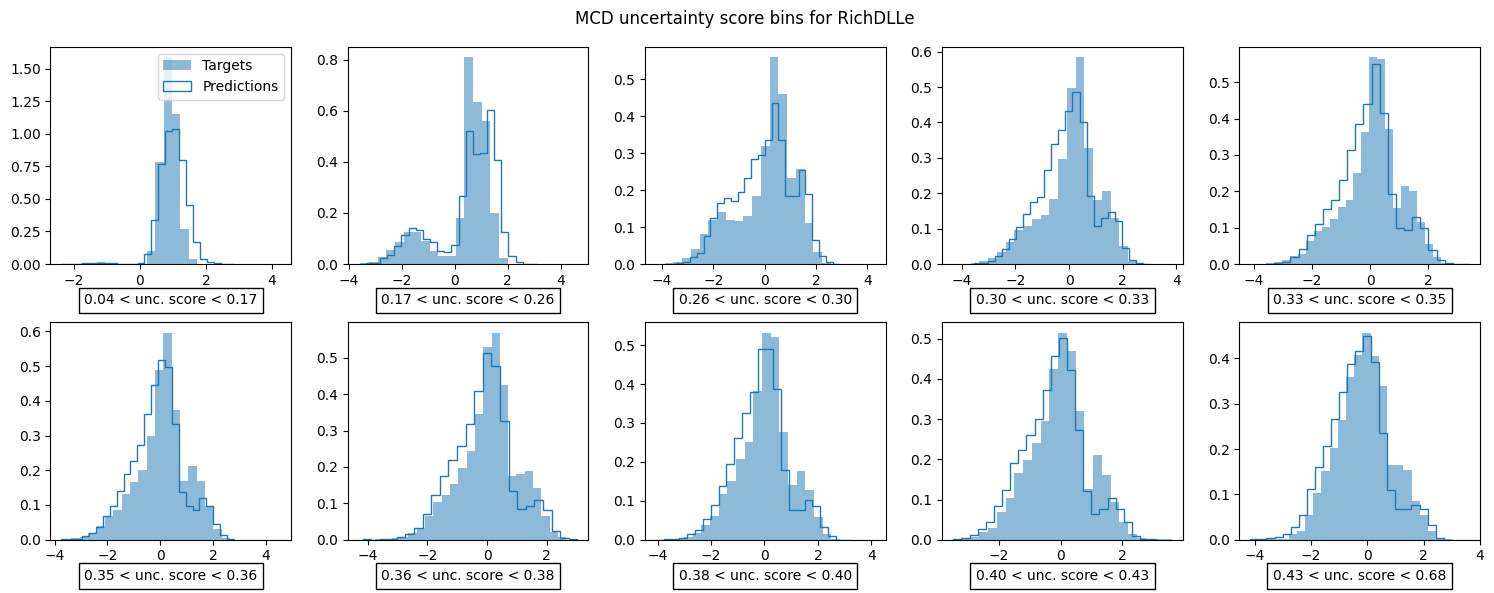

0.04 < unc. score < 0.17: JS-Distance: 0.72 Number of observations: 10000
0.17 < unc. score < 0.26: JS-Distance: 0.54 Number of observations: 10000
0.26 < unc. score < 0.30: JS-Distance: 0.26 Number of observations: 10000
0.30 < unc. score < 0.33: JS-Distance: 0.15 Number of observations: 10000
0.33 < unc. score < 0.35: JS-Distance: 0.33 Number of observations: 10000
0.35 < unc. score < 0.36: JS-Distance: 0.33 Number of observations: 10000
0.36 < unc. score < 0.38: JS-Distance: 0.19 Number of observations: 10000
0.38 < unc. score < 0.40: JS-Distance: 0.13 Number of observations: 10000
0.40 < unc. score < 0.43: JS-Distance: 0.09 Number of observations: 10000
0.43 < unc. score < 0.68: JS-Distance: 0.14 Number of observations: 9999


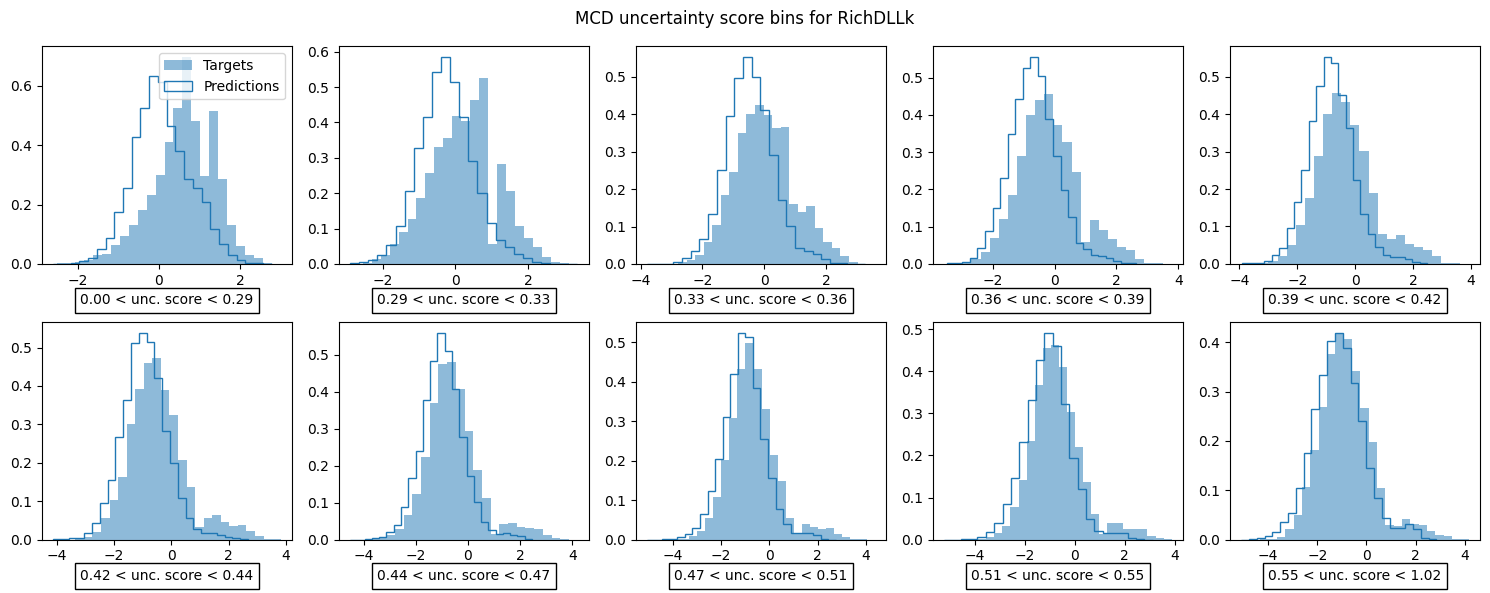

0.00 < unc. score < 0.29: JS-Distance: 0.20 Number of observations: 10000
0.29 < unc. score < 0.33: JS-Distance: 0.19 Number of observations: 10000
0.33 < unc. score < 0.36: JS-Distance: 0.11 Number of observations: 10000
0.36 < unc. score < 0.39: JS-Distance: 0.06 Number of observations: 10000
0.39 < unc. score < 0.42: JS-Distance: 0.10 Number of observations: 10000
0.42 < unc. score < 0.44: JS-Distance: 0.18 Number of observations: 10000
0.44 < unc. score < 0.47: JS-Distance: 0.27 Number of observations: 10000
0.47 < unc. score < 0.51: JS-Distance: 0.36 Number of observations: 10000
0.51 < unc. score < 0.55: JS-Distance: 0.25 Number of observations: 10000
0.55 < unc. score < 1.02: JS-Distance: 0.25 Number of observations: 9999


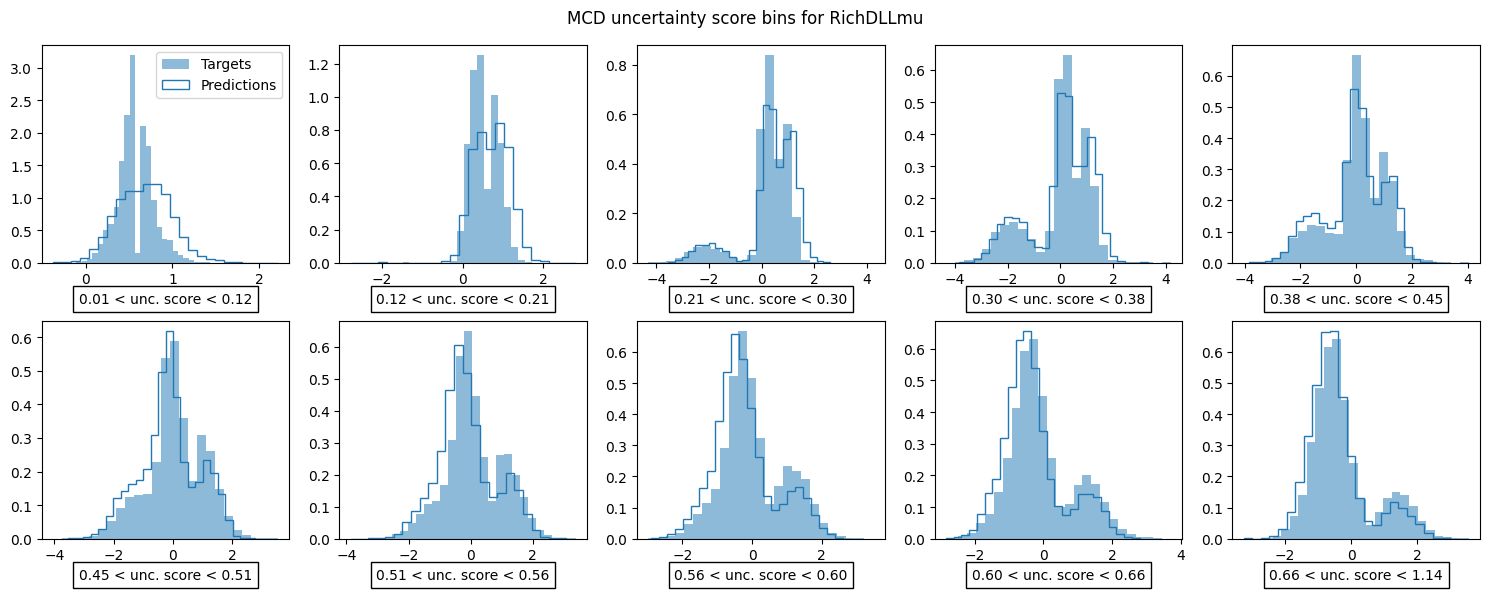

0.01 < unc. score < 0.12: JS-Distance: 0.13 Number of observations: 10000
0.12 < unc. score < 0.21: JS-Distance: 0.41 Number of observations: 10000
0.21 < unc. score < 0.30: JS-Distance: 0.50 Number of observations: 10000
0.30 < unc. score < 0.38: JS-Distance: 0.23 Number of observations: 10000
0.38 < unc. score < 0.45: JS-Distance: 0.23 Number of observations: 10000
0.45 < unc. score < 0.51: JS-Distance: 0.13 Number of observations: 10000
0.51 < unc. score < 0.56: JS-Distance: 0.20 Number of observations: 10000
0.56 < unc. score < 0.60: JS-Distance: 0.12 Number of observations: 10000
0.60 < unc. score < 0.66: JS-Distance: 0.16 Number of observations: 10000
0.66 < unc. score < 1.14: JS-Distance: 0.15 Number of observations: 9999


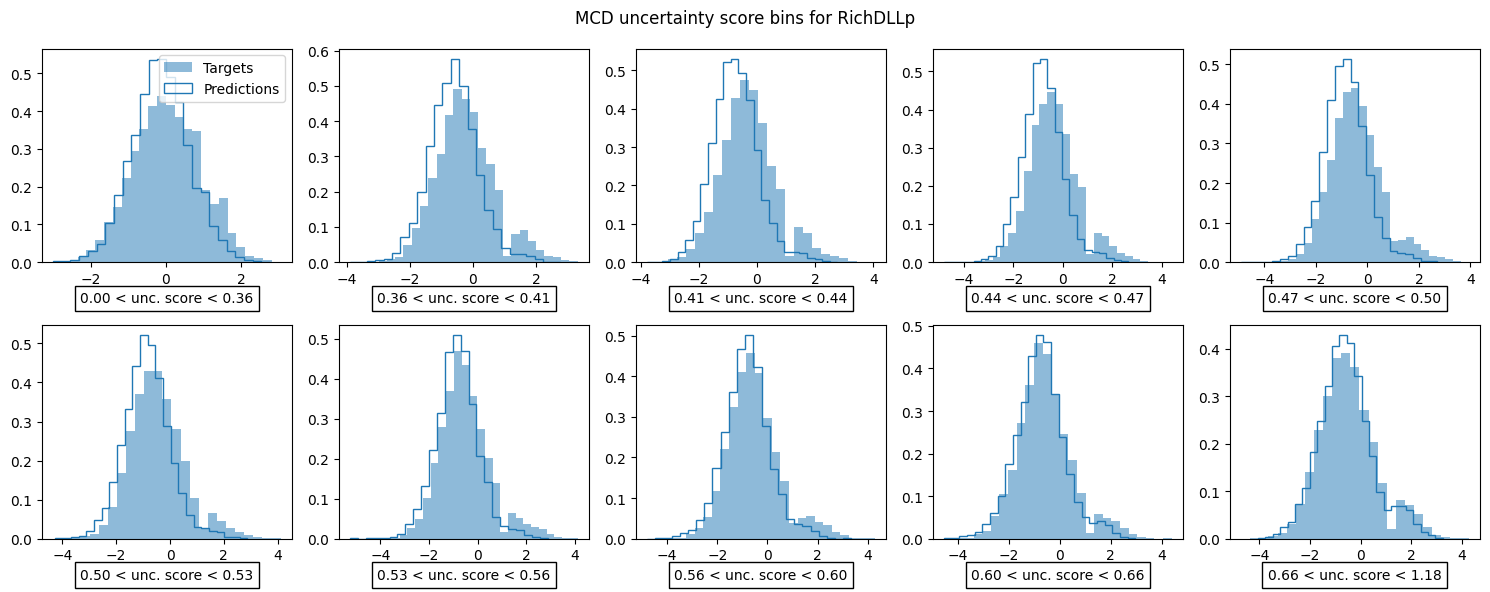

0.00 < unc. score < 0.36: JS-Distance: 0.08 Number of observations: 10000
0.36 < unc. score < 0.41: JS-Distance: 0.15 Number of observations: 10000
0.41 < unc. score < 0.44: JS-Distance: 0.09 Number of observations: 10000
0.44 < unc. score < 0.47: JS-Distance: 0.40 Number of observations: 10000
0.47 < unc. score < 0.50: JS-Distance: 0.33 Number of observations: 10000
0.50 < unc. score < 0.53: JS-Distance: 0.09 Number of observations: 10000
0.53 < unc. score < 0.56: JS-Distance: 0.38 Number of observations: 10000
0.56 < unc. score < 0.60: JS-Distance: 0.18 Number of observations: 10000
0.60 < unc. score < 0.66: JS-Distance: 0.27 Number of observations: 10000
0.66 < unc. score < 1.18: JS-Distance: 0.08 Number of observations: 9999


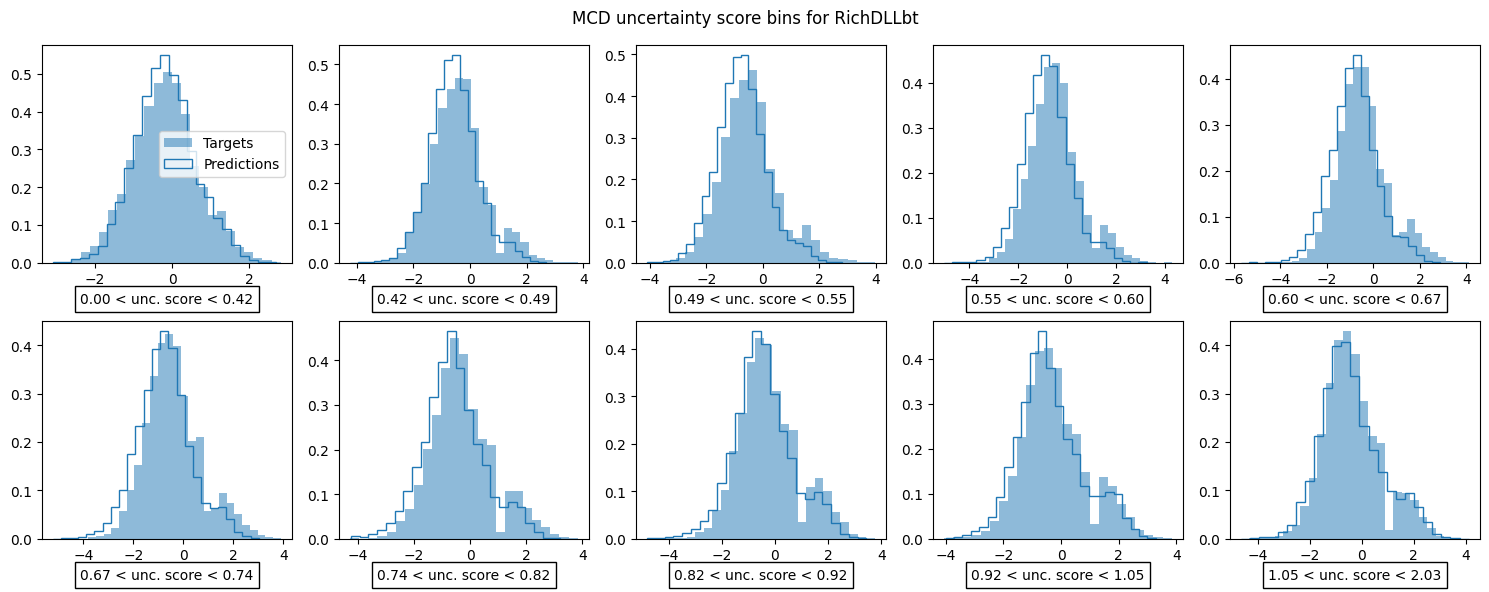

0.00 < unc. score < 0.42: JS-Distance: 0.05 Number of observations: 10000
0.42 < unc. score < 0.49: JS-Distance: 0.31 Number of observations: 10000
0.49 < unc. score < 0.55: JS-Distance: 0.12 Number of observations: 10000
0.55 < unc. score < 0.60: JS-Distance: 0.28 Number of observations: 10000
0.60 < unc. score < 0.67: JS-Distance: 0.33 Number of observations: 10000
0.67 < unc. score < 0.74: JS-Distance: 0.28 Number of observations: 10000
0.74 < unc. score < 0.82: JS-Distance: 0.07 Number of observations: 10000
0.82 < unc. score < 0.92: JS-Distance: 0.09 Number of observations: 10000
0.92 < unc. score < 1.05: JS-Distance: 0.07 Number of observations: 10000
1.05 < unc. score < 2.03: JS-Distance: 0.03 Number of observations: 9999


In [183]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

for i in range(5):
  plot_uncertainty_bins(y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', particle_index = i)
  mcd_bin_edges, mcd_js_distances = estimate_distances_per_quantiles(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', particle_index = i,  quantile=0.1)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

Correlation coefficient for RichDLLe: -0.9186433850480078
Correlation coefficient for RichDLLk: 0.31285509343562745
Correlation coefficient for RichDLLmu: -0.4966293716341452
Correlation coefficient for RichDLLp: 0.27148815301250356
Correlation coefficient for RichDLLbt: -0.22816628434661987


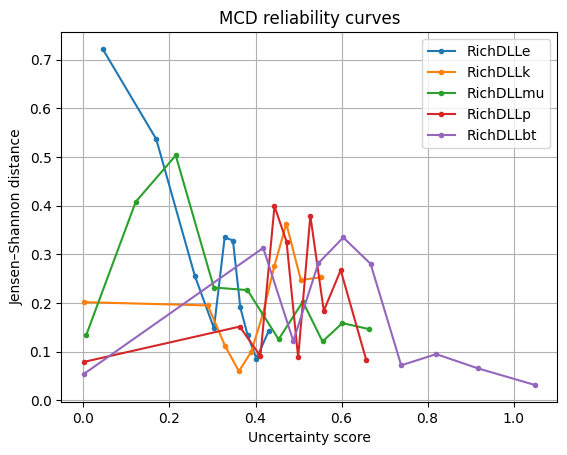

In [179]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD')

-----------------------------------

0.04 < unc. score < 0.11: Number of observations: 3964
0.11 < unc. score < 0.17: Number of observations: 6320
0.17 < unc. score < 0.24: Number of observations: 6588
0.24 < unc. score < 0.30: Number of observations: 11995
0.30 < unc. score < 0.36: Number of observations: 30455
0.36 < unc. score < 0.43: Number of observations: 29690
0.43 < unc. score < 0.49: Number of observations: 9464
0.49 < unc. score < 0.55: Number of observations: 1370
0.55 < unc. score < 0.62: Number of observations: 137
0.62 < unc. score < 0.68: Number of observations: 16


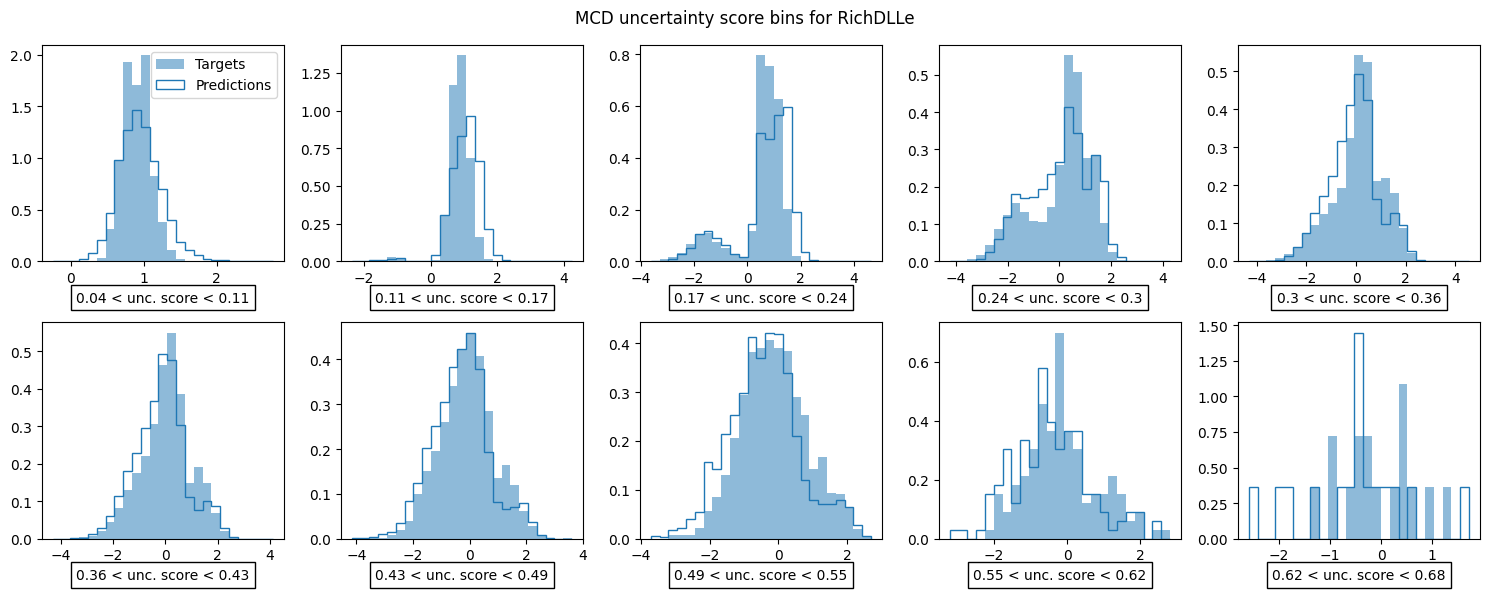

Jensen–Shannon distances:
0.20385067066466453, 0.2562077140334703, 0.21623574735287737, 0.1338360454024174, 0.1137253104142244, 0.10390743602599795, 0.10839383137761406, 0.13320245135096287, 0.2242183264042402, 0.5454530909090141
0.00 < unc. score < 0.10: Number of observations: 276
0.10 < unc. score < 0.20: Number of observations: 377
0.20 < unc. score < 0.31: Number of observations: 13521
0.31 < unc. score < 0.41: Number of observations: 32702
0.41 < unc. score < 0.51: Number of observations: 34489
0.51 < unc. score < 0.61: Number of observations: 14865
0.61 < unc. score < 0.71: Number of observations: 3241
0.71 < unc. score < 0.82: Number of observations: 482
0.82 < unc. score < 0.92: Number of observations: 44
0.92 < unc. score < 1.02: Number of observations: 2


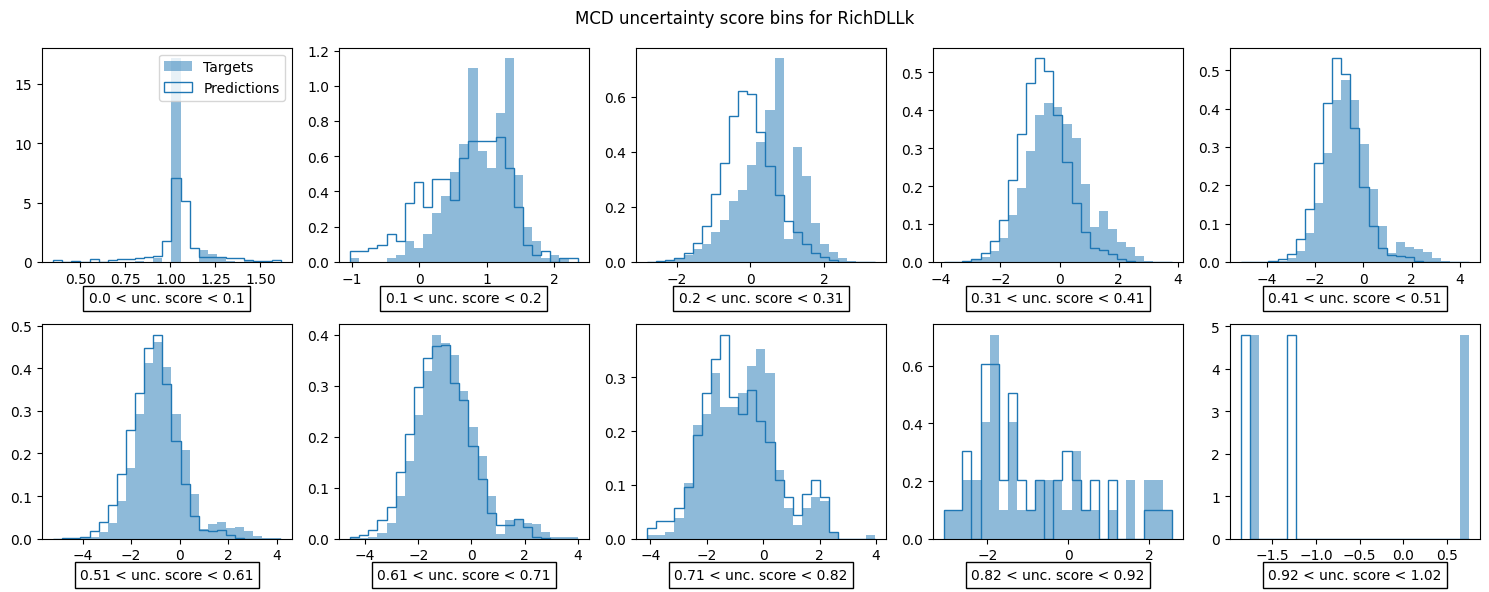

Jensen–Shannon distances:
0.49047747602442565, 0.23570218171807544, 0.28883741888377257, 0.20476822895371272, 0.17103581826828765, 0.14096548091339364, 0.11600290446681048, 0.11884308755531313, 0.2653986473237288, 0.8325546111576978
0.01 < unc. score < 0.12: Number of observations: 9750
0.12 < unc. score < 0.23: Number of observations: 12093
0.23 < unc. score < 0.35: Number of observations: 13645
0.35 < unc. score < 0.46: Number of observations: 15413
0.46 < unc. score < 0.57: Number of observations: 22834
0.57 < unc. score < 0.69: Number of observations: 18808
0.69 < unc. score < 0.80: Number of observations: 6322
0.80 < unc. score < 0.91: Number of observations: 1045
0.91 < unc. score < 1.03: Number of observations: 86
1.03 < unc. score < 1.14: Number of observations: 3


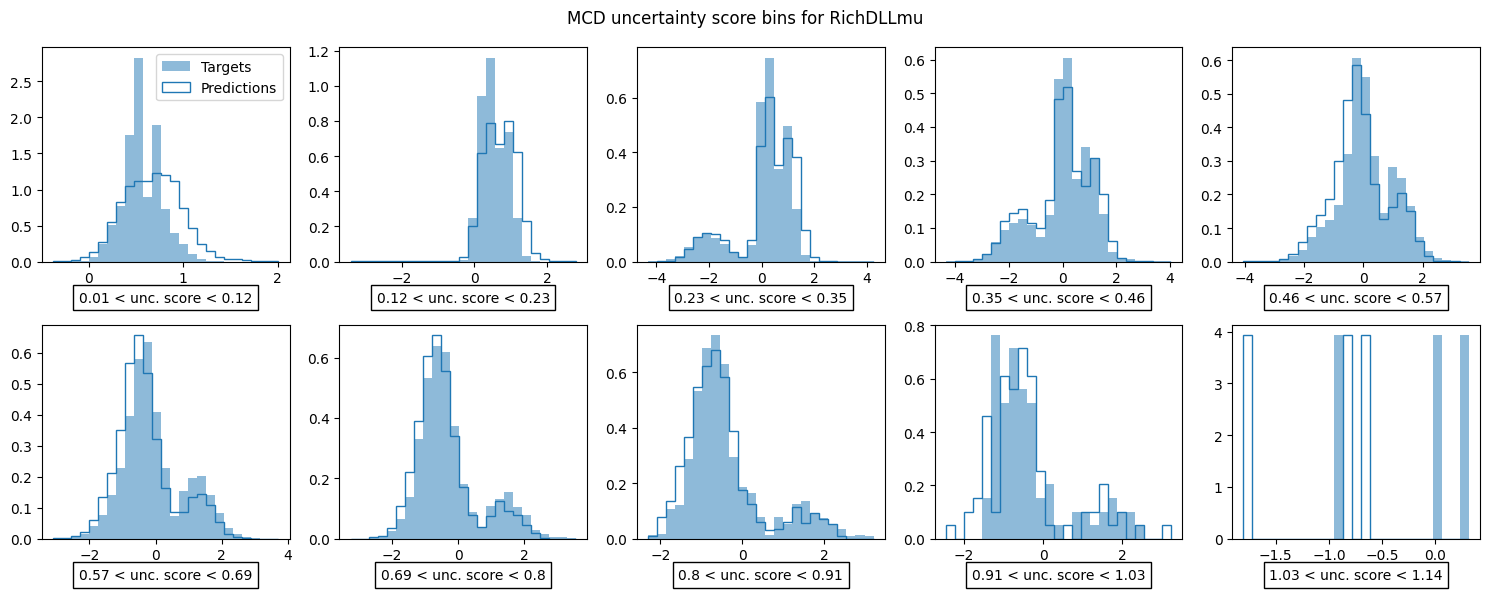

Jensen–Shannon distances:
0.2547711112878707, 0.18901265491785826, 0.1320860934678954, 0.08707031580830304, 0.11838021155222032, 0.1175478649603672, 0.0864773551015358, 0.11783973545743204, 0.33235296400914777, 0.8325546111576977
0.00 < unc. score < 0.12: Number of observations: 309
0.12 < unc. score < 0.24: Number of observations: 731
0.24 < unc. score < 0.36: Number of observations: 7803
0.36 < unc. score < 0.47: Number of observations: 31511
0.47 < unc. score < 0.59: Number of observations: 38147
0.59 < unc. score < 0.71: Number of observations: 16389
0.71 < unc. score < 0.83: Number of observations: 4088
0.83 < unc. score < 0.95: Number of observations: 838
0.95 < unc. score < 1.06: Number of observations: 167
1.06 < unc. score < 1.18: Number of observations: 16


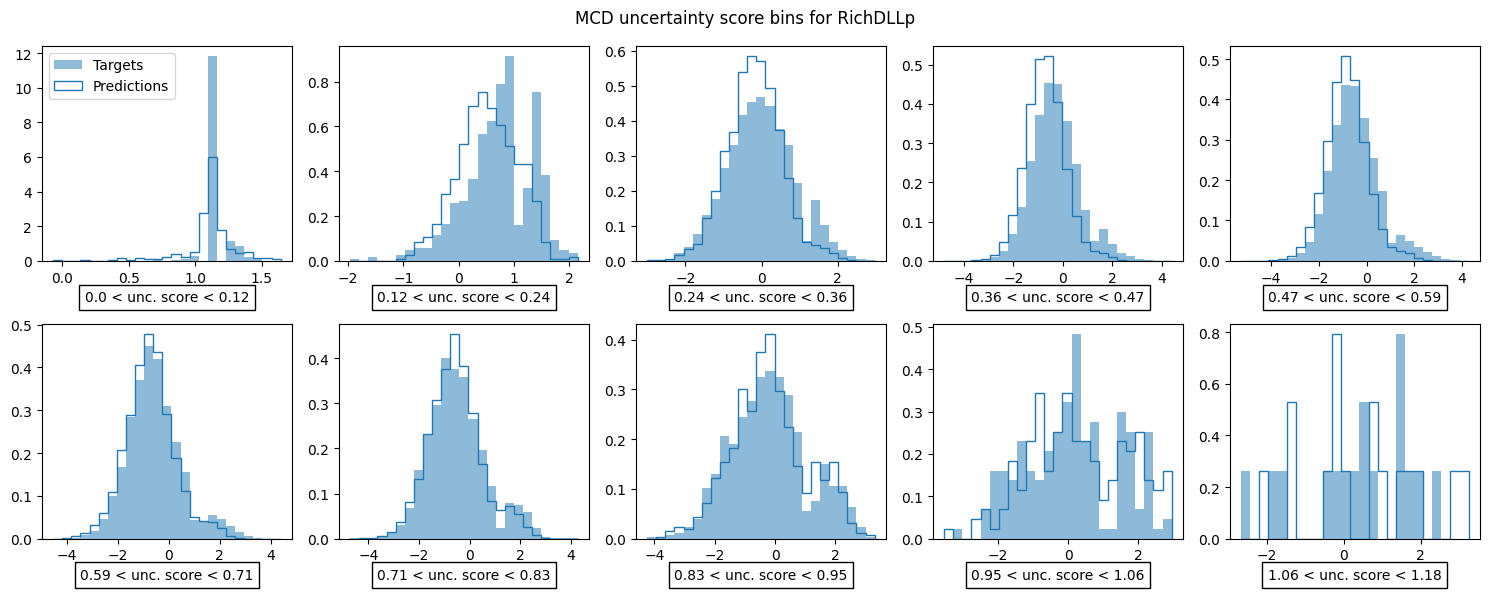

Jensen–Shannon distances:
0.42430373561636797, 0.22339413525099913, 0.12600281157139787, 0.17669948063486884, 0.14401822431381262, 0.08294704396177989, 0.08038151268656367, 0.09960557669656965, 0.2523060715772204, 0.565334750949311
0.00 < unc. score < 0.20: Number of observations: 620
0.20 < unc. score < 0.41: Number of observations: 8043
0.41 < unc. score < 0.61: Number of observations: 32084
0.61 < unc. score < 0.81: Number of observations: 28150
0.81 < unc. score < 1.01: Number of observations: 18825
1.01 < unc. score < 1.22: Number of observations: 9271
1.22 < unc. score < 1.42: Number of observations: 2551
1.42 < unc. score < 1.62: Number of observations: 398
1.62 < unc. score < 1.82: Number of observations: 51
1.82 < unc. score < 2.03: Number of observations: 6


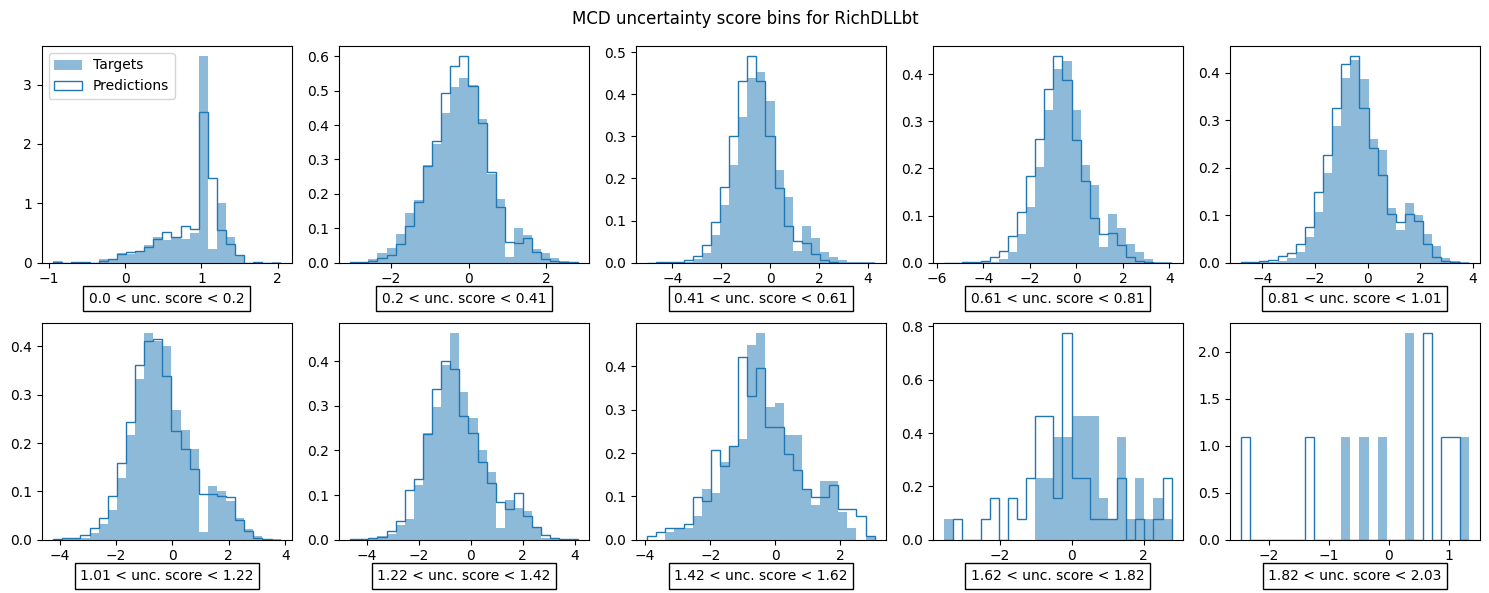

Jensen–Shannon distances:
0.20327994286106346, 0.07273171769610882, 0.12042269892246002, 0.1355623178522162, 0.08264327590000135, 0.09345504850843703, 0.09614436187917885, 0.14554375632332142, 0.3983239651717775, 0.8325546111576977


In [160]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', particle_index = i)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]


Correlation coefficient for RichDLLe: 0.29781417383693953
Correlation coefficient for RichDLLk: 0.20743677757479131
Correlation coefficient for RichDLLmu: 0.4830114007779016
Correlation coefficient for RichDLLp: 0.0860188810937452
Correlation coefficient for RichDLLbt: 0.513703136157555


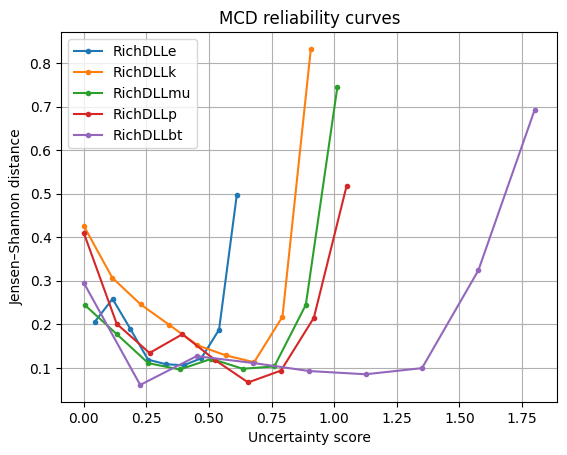

In [47]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD')

## Feature Densities method

### Uncertainty estimation

In [29]:
from feature_densities.feature_density_evaluator import evaluate_model as fd_evaluate_model

train_embeddings = np.load(embeddings_dir + f'{PARTICLE}_train_embeddings.npy')
train_embeddings.shape

(948325, 128)

In [31]:
fd_uncertainty_normalized, _ = fd_evaluate_model(model, x_sample, known_embeddings=train_embeddings, n_fit_samples=100,
                                                 likelihood_method='normalized')

print('Feature Densities using NORMALIZED uncertainty score for x_sample:')
fd_uncertainty_normalized.shape

Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 11s 3ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:35<00:00,  3.64it/s]


Feature Densities using NORMALIZED uncertainty score for x_sample:


TensorShape([100000])

In [32]:
# Save FD uncertainties normalized
np.save(output_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy', fd_uncertainty_normalized)

### Plot FD uncertainties

#### Quantile bins

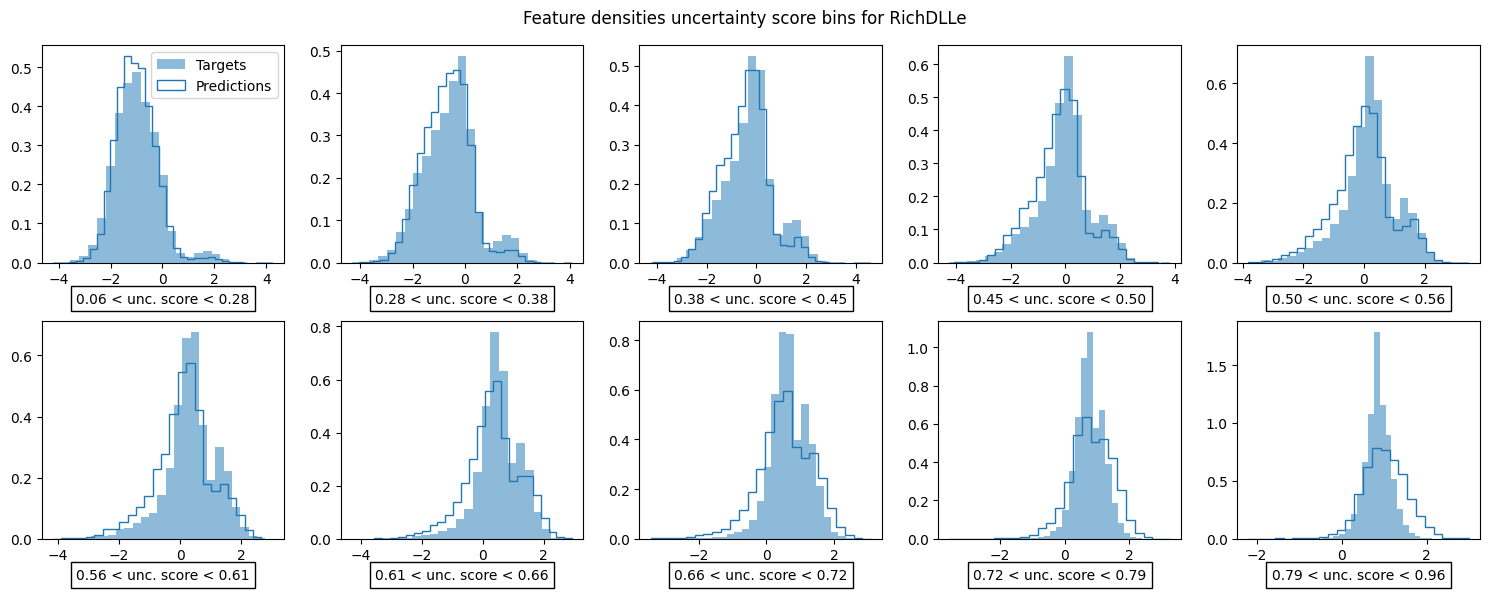

0.06 < unc. score < 0.28: JS-Distance: 0.09 Number of observations: 10000
0.28 < unc. score < 0.38: JS-Distance: 0.16 Number of observations: 10000
0.38 < unc. score < 0.45: JS-Distance: 0.23 Number of observations: 10000
0.45 < unc. score < 0.50: JS-Distance: 0.07 Number of observations: 10000
0.50 < unc. score < 0.56: JS-Distance: 0.16 Number of observations: 10000
0.56 < unc. score < 0.61: JS-Distance: 0.14 Number of observations: 10000
0.61 < unc. score < 0.66: JS-Distance: 0.26 Number of observations: 10000
0.66 < unc. score < 0.72: JS-Distance: 0.16 Number of observations: 10000
0.72 < unc. score < 0.79: JS-Distance: 0.09 Number of observations: 10000
0.79 < unc. score < 0.96: JS-Distance: 0.09 Number of observations: 9999


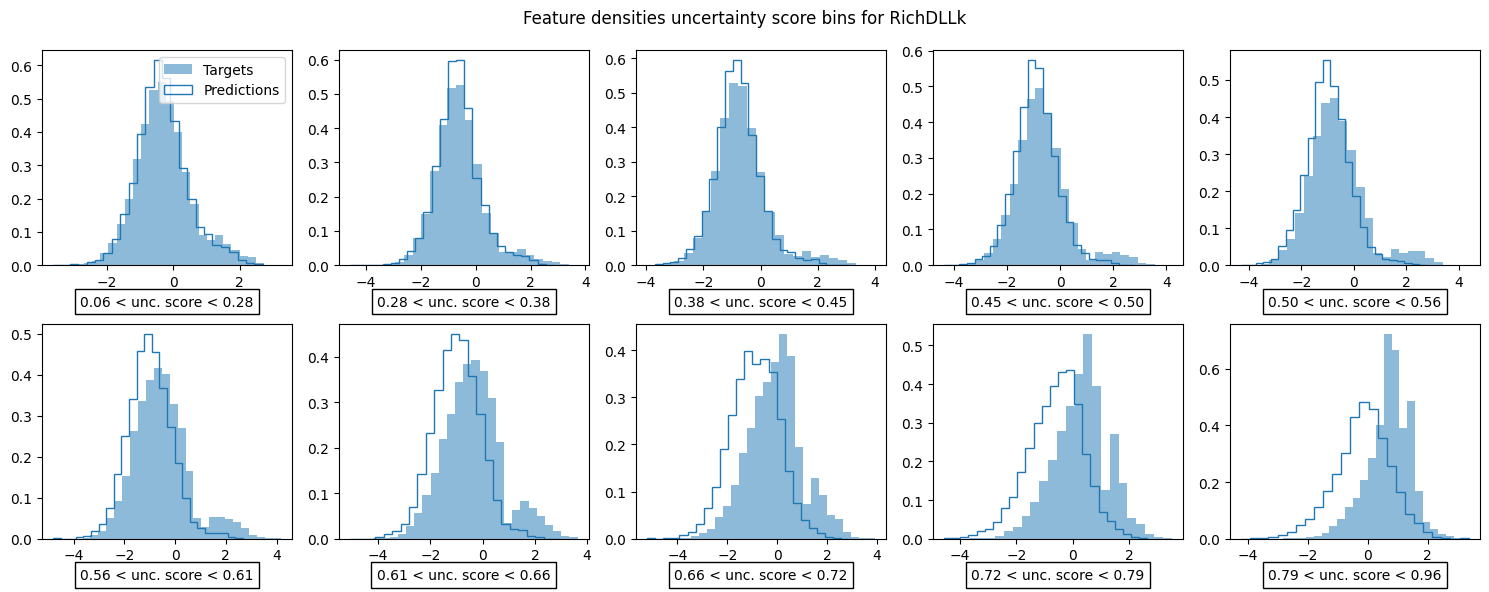

0.06 < unc. score < 0.28: JS-Distance: 0.26 Number of observations: 10000
0.28 < unc. score < 0.38: JS-Distance: 0.25 Number of observations: 10000
0.38 < unc. score < 0.45: JS-Distance: 0.07 Number of observations: 10000
0.45 < unc. score < 0.50: JS-Distance: 0.31 Number of observations: 10000
0.50 < unc. score < 0.56: JS-Distance: 0.26 Number of observations: 10000
0.56 < unc. score < 0.61: JS-Distance: 0.33 Number of observations: 10000
0.61 < unc. score < 0.66: JS-Distance: 0.15 Number of observations: 10000
0.66 < unc. score < 0.72: JS-Distance: 0.13 Number of observations: 10000
0.72 < unc. score < 0.79: JS-Distance: 0.12 Number of observations: 10000
0.79 < unc. score < 0.96: JS-Distance: 0.29 Number of observations: 9999


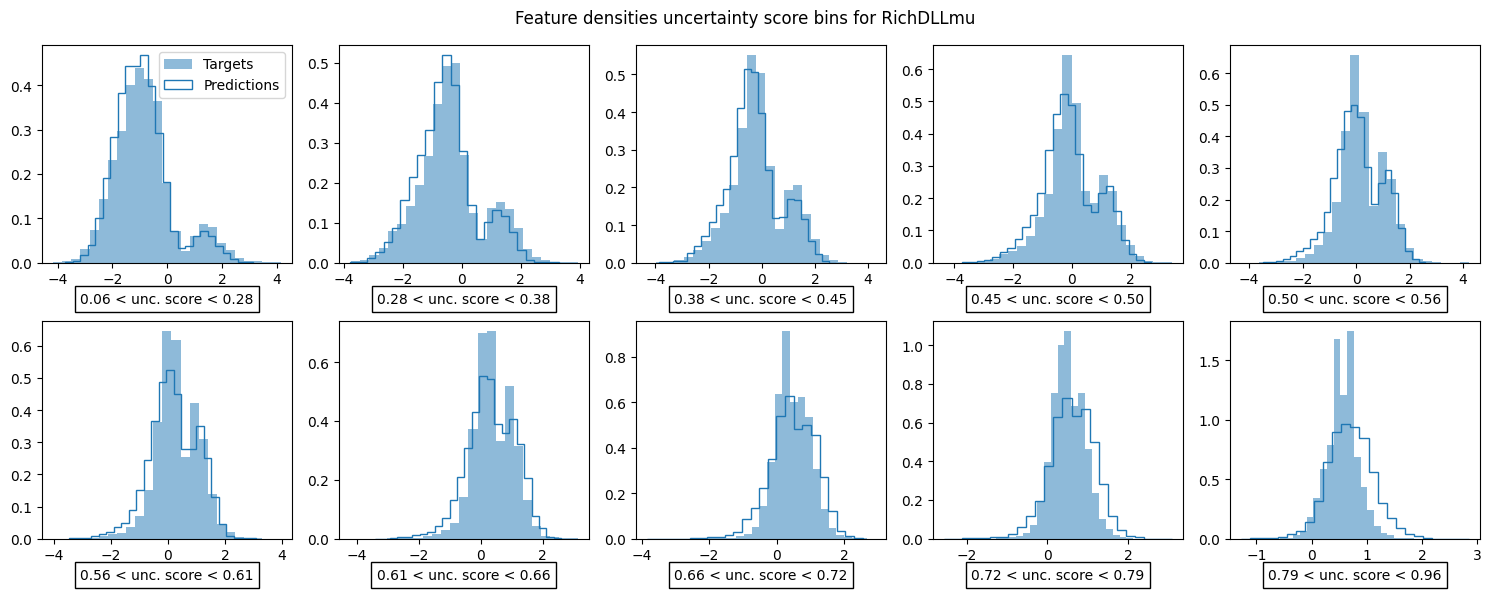

0.06 < unc. score < 0.28: JS-Distance: 0.10 Number of observations: 10000
0.28 < unc. score < 0.38: JS-Distance: 0.11 Number of observations: 10000
0.38 < unc. score < 0.45: JS-Distance: 0.19 Number of observations: 10000
0.45 < unc. score < 0.50: JS-Distance: 0.12 Number of observations: 10000
0.50 < unc. score < 0.56: JS-Distance: 0.21 Number of observations: 10000
0.56 < unc. score < 0.61: JS-Distance: 0.17 Number of observations: 10000
0.61 < unc. score < 0.66: JS-Distance: 0.18 Number of observations: 10000
0.66 < unc. score < 0.72: JS-Distance: 0.35 Number of observations: 10000
0.72 < unc. score < 0.79: JS-Distance: 0.23 Number of observations: 10000
0.79 < unc. score < 0.96: JS-Distance: 0.33 Number of observations: 9999


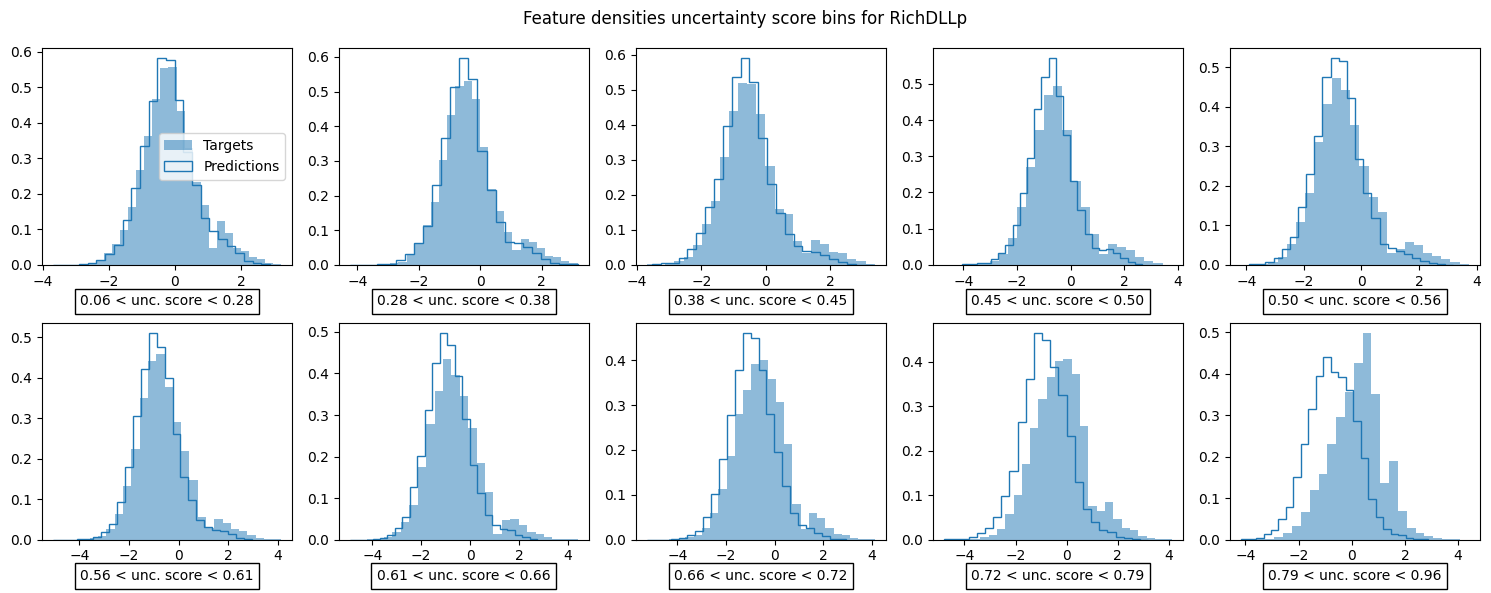

0.06 < unc. score < 0.28: JS-Distance: 0.24 Number of observations: 10000
0.28 < unc. score < 0.38: JS-Distance: 0.17 Number of observations: 10000
0.38 < unc. score < 0.45: JS-Distance: 0.10 Number of observations: 10000
0.45 < unc. score < 0.50: JS-Distance: 0.07 Number of observations: 10000
0.50 < unc. score < 0.56: JS-Distance: 0.07 Number of observations: 10000
0.56 < unc. score < 0.61: JS-Distance: 0.30 Number of observations: 10000
0.61 < unc. score < 0.66: JS-Distance: 0.32 Number of observations: 10000
0.66 < unc. score < 0.72: JS-Distance: 0.24 Number of observations: 10000
0.72 < unc. score < 0.79: JS-Distance: 0.12 Number of observations: 10000
0.79 < unc. score < 0.96: JS-Distance: 0.07 Number of observations: 9999


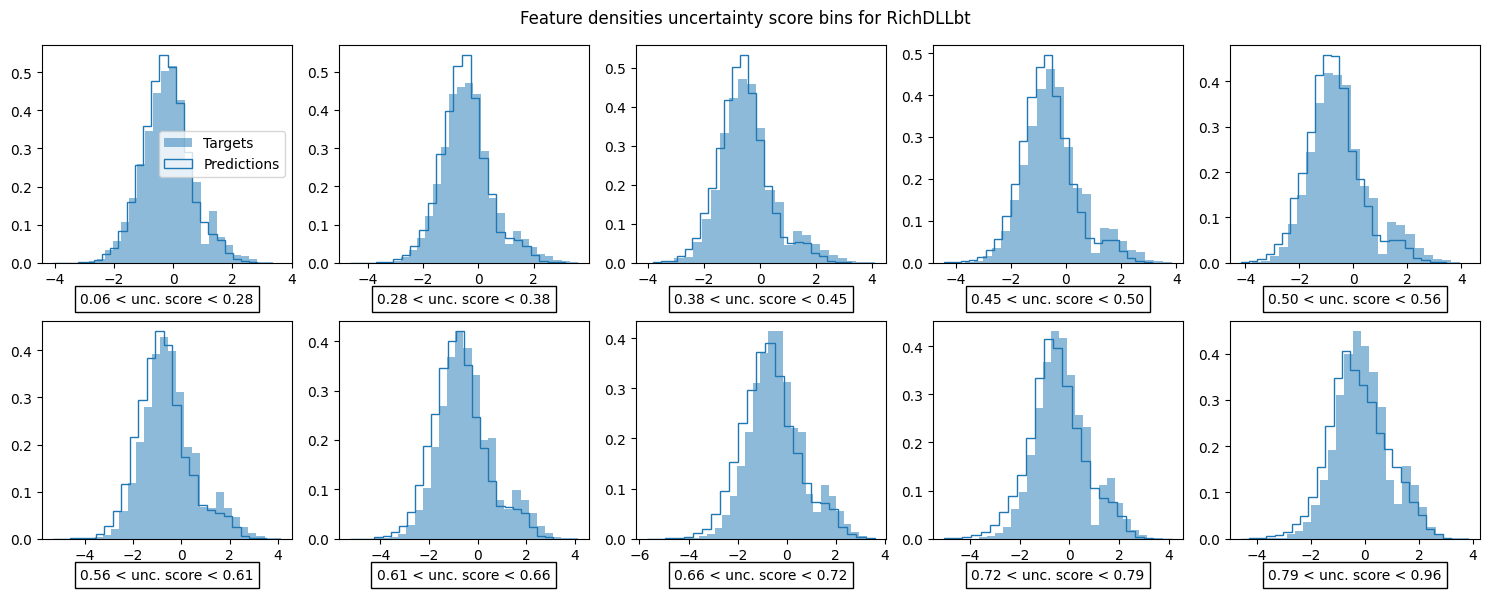

0.06 < unc. score < 0.28: JS-Distance: 0.33 Number of observations: 10000
0.28 < unc. score < 0.38: JS-Distance: 0.26 Number of observations: 10000
0.38 < unc. score < 0.45: JS-Distance: 0.06 Number of observations: 10000
0.45 < unc. score < 0.50: JS-Distance: 0.08 Number of observations: 10000
0.50 < unc. score < 0.56: JS-Distance: 0.07 Number of observations: 10000
0.56 < unc. score < 0.61: JS-Distance: 0.20 Number of observations: 10000
0.61 < unc. score < 0.66: JS-Distance: 0.23 Number of observations: 10000
0.66 < unc. score < 0.72: JS-Distance: 0.16 Number of observations: 10000
0.72 < unc. score < 0.79: JS-Distance: 0.06 Number of observations: 10000
0.79 < unc. score < 0.96: JS-Distance: 0.18 Number of observations: 9999


In [184]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  plot_uncertainty_bins(y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', particle_index = i)
  fd_bin_edges, fd_js_distances = estimate_distances_per_quantiles(y_sample, t_generated, fd_uncertainty_normalized,
                                                                   uncertainty_type = 'FD', particle_index = i)
  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]


Correlation coefficient for RichDLLe: 0.02639562103805779
Correlation coefficient for RichDLLk: -0.16810818143385461
Correlation coefficient for RichDLLmu: 0.7837628875535272
Correlation coefficient for RichDLLp: -0.1198260063567947
Correlation coefficient for RichDLLbt: -0.44926604847247054


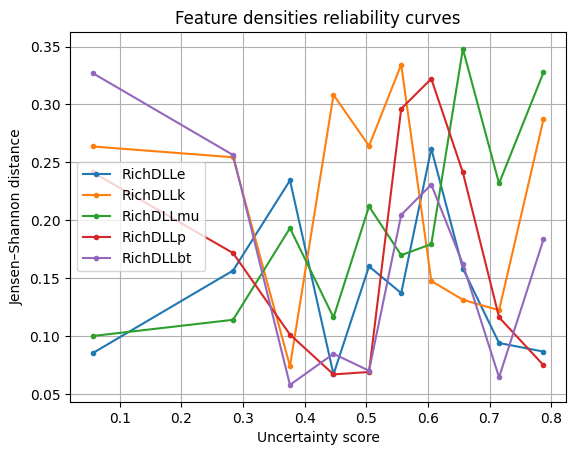

In [185]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')

__________________________________________________________
#### Fixed bins

0.06 < unc. score < 0.15: Number of observations: 1056
0.15 < unc. score < 0.24: Number of observations: 5091
0.24 < unc. score < 0.33: Number of observations: 8055
0.33 < unc. score < 0.42: Number of observations: 11206
0.42 < unc. score < 0.51: Number of observations: 15000
0.51 < unc. score < 0.60: Number of observations: 17760
0.60 < unc. score < 0.69: Number of observations: 17145
0.69 < unc. score < 0.78: Number of observations: 13356
0.78 < unc. score < 0.87: Number of observations: 9633
0.87 < unc. score < 0.96: Number of observations: 1697


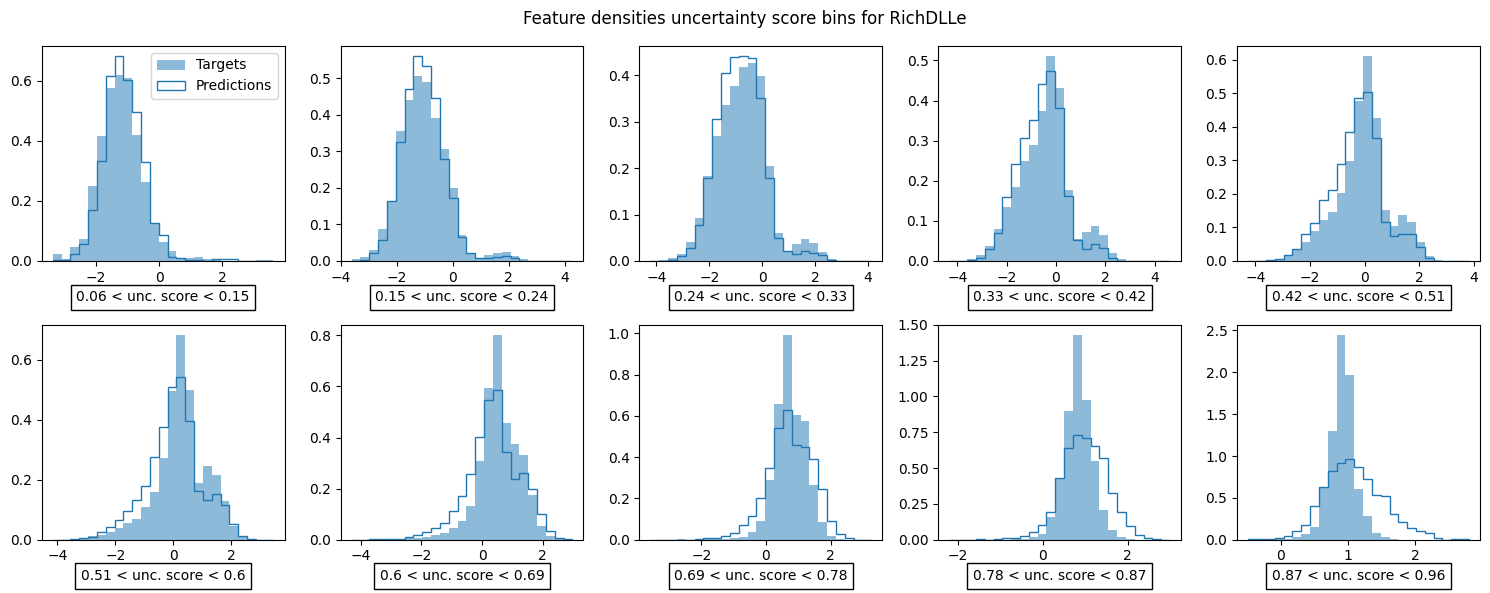

Jensen–Shannon distances:
0.0966127228565879, 0.061793410179067414, 0.07006930474757163, 0.0910156664128152, 0.09481665113313857, 0.11977882401902032, 0.1456655290768403, 0.1817718830821343, 0.24045081973566562, 0.3508234063025111
0.06 < unc. score < 0.15: Number of observations: 1056
0.15 < unc. score < 0.24: Number of observations: 5091
0.24 < unc. score < 0.33: Number of observations: 8055
0.33 < unc. score < 0.42: Number of observations: 11206
0.42 < unc. score < 0.51: Number of observations: 15000
0.51 < unc. score < 0.60: Number of observations: 17760
0.60 < unc. score < 0.69: Number of observations: 17145
0.69 < unc. score < 0.78: Number of observations: 13356
0.78 < unc. score < 0.87: Number of observations: 9633
0.87 < unc. score < 0.96: Number of observations: 1697


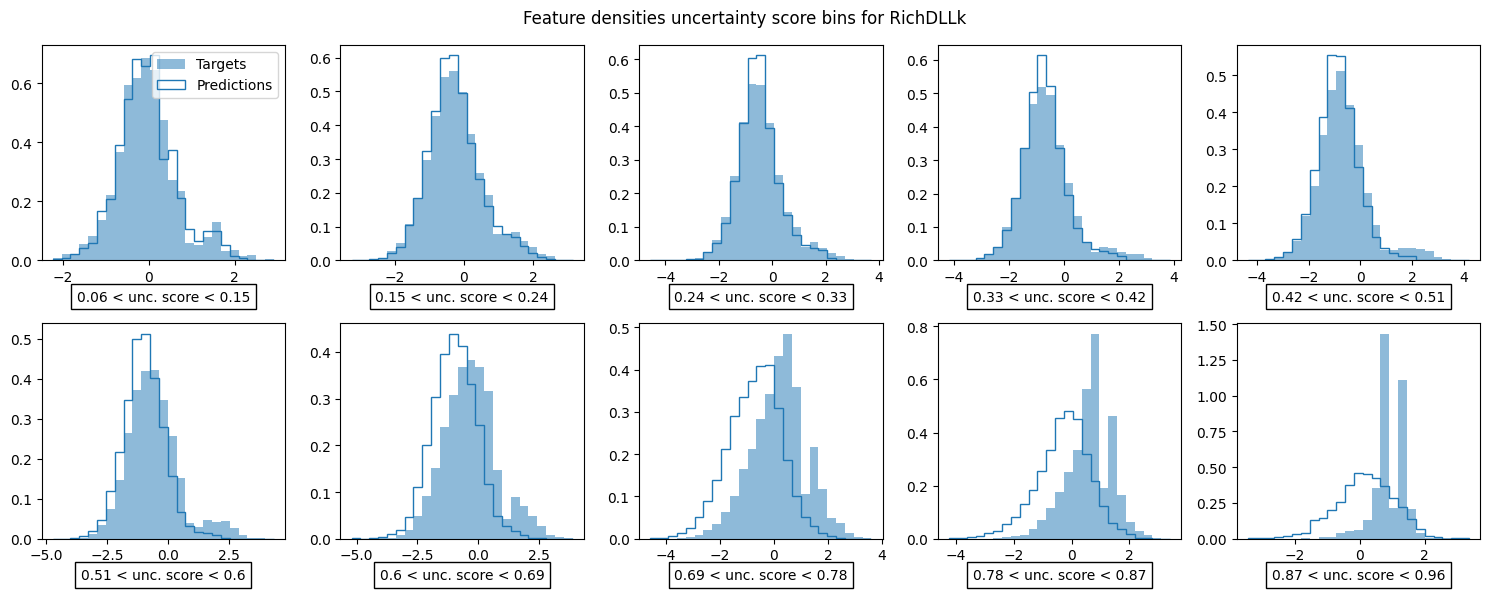

Jensen–Shannon distances:
0.08218656453619376, 0.04890149835488488, 0.06458973248932154, 0.08180127327958692, 0.11201577654398358, 0.16024064803799826, 0.23469565763731529, 0.31038211138062116, 0.3661131814120872, 0.4566781962205286
0.06 < unc. score < 0.15: Number of observations: 1056
0.15 < unc. score < 0.24: Number of observations: 5091
0.24 < unc. score < 0.33: Number of observations: 8055
0.33 < unc. score < 0.42: Number of observations: 11206
0.42 < unc. score < 0.51: Number of observations: 15000
0.51 < unc. score < 0.60: Number of observations: 17760
0.60 < unc. score < 0.69: Number of observations: 17145
0.69 < unc. score < 0.78: Number of observations: 13356
0.78 < unc. score < 0.87: Number of observations: 9633
0.87 < unc. score < 0.96: Number of observations: 1697


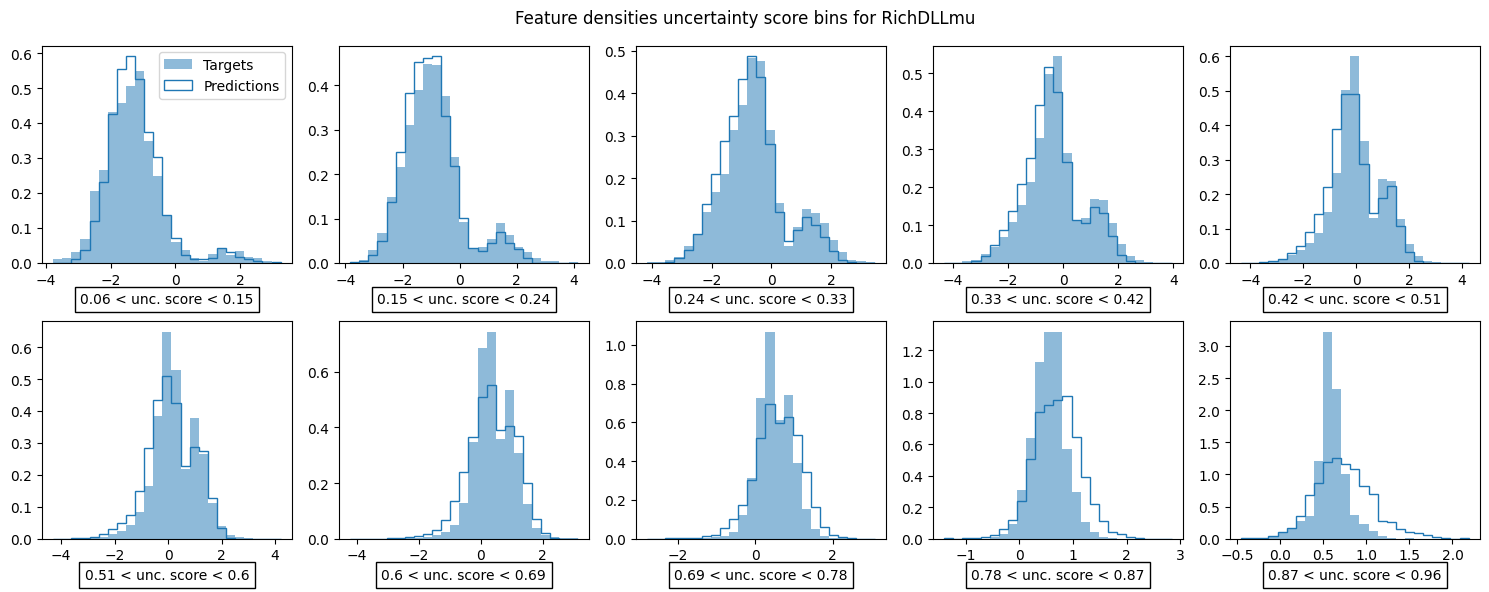

Jensen–Shannon distances:
0.09520810909221725, 0.07293570720221959, 0.07575983567385293, 0.08734764590161152, 0.09842110236257265, 0.10926506399520852, 0.12938092822737277, 0.15710661878318075, 0.20673780056642396, 0.3166504474686815
0.06 < unc. score < 0.15: Number of observations: 1056
0.15 < unc. score < 0.24: Number of observations: 5091
0.24 < unc. score < 0.33: Number of observations: 8055
0.33 < unc. score < 0.42: Number of observations: 11206
0.42 < unc. score < 0.51: Number of observations: 15000
0.51 < unc. score < 0.60: Number of observations: 17760
0.60 < unc. score < 0.69: Number of observations: 17145
0.69 < unc. score < 0.78: Number of observations: 13356
0.78 < unc. score < 0.87: Number of observations: 9633
0.87 < unc. score < 0.96: Number of observations: 1697


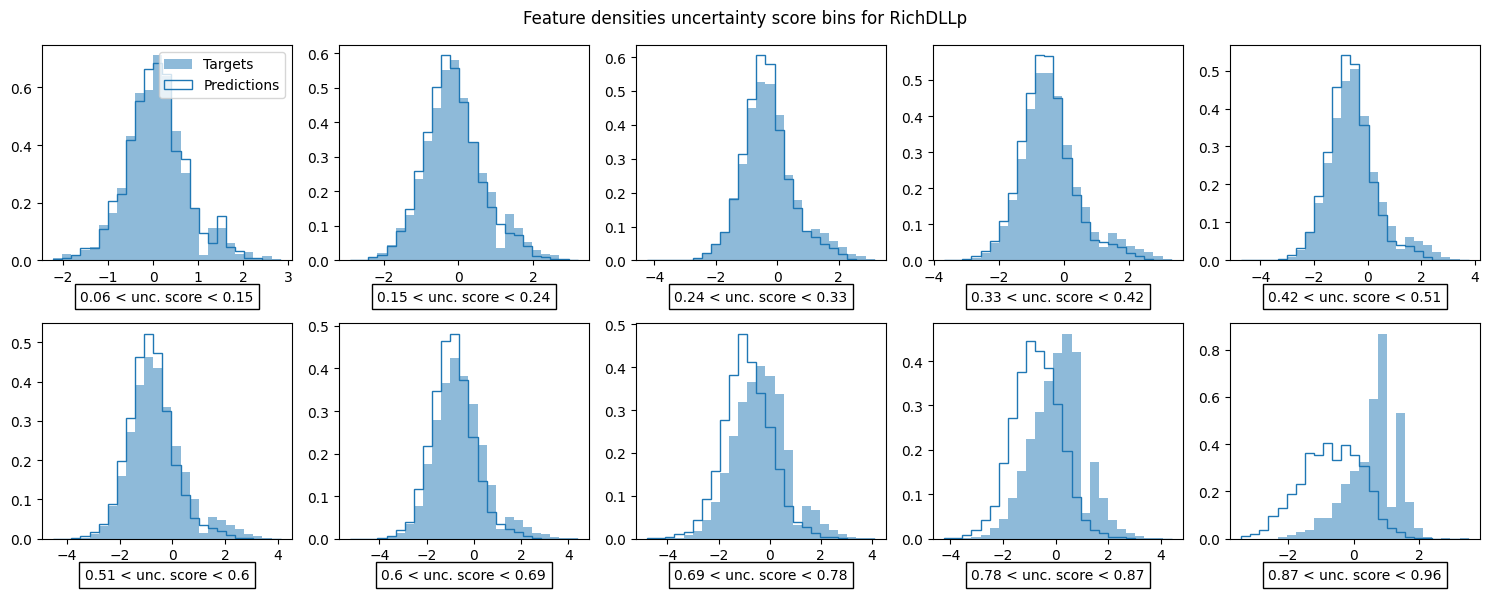

Jensen–Shannon distances:
0.0860402384189913, 0.07561322385147246, 0.06647192415233343, 0.08146078358472658, 0.09525975491177392, 0.11093560224638412, 0.12716648181269125, 0.1975253031648827, 0.3046568474805308, 0.47882578906323897
0.06 < unc. score < 0.15: Number of observations: 1056
0.15 < unc. score < 0.24: Number of observations: 5091
0.24 < unc. score < 0.33: Number of observations: 8055
0.33 < unc. score < 0.42: Number of observations: 11206
0.42 < unc. score < 0.51: Number of observations: 15000
0.51 < unc. score < 0.60: Number of observations: 17760
0.60 < unc. score < 0.69: Number of observations: 17145
0.69 < unc. score < 0.78: Number of observations: 13356
0.78 < unc. score < 0.87: Number of observations: 9633
0.87 < unc. score < 0.96: Number of observations: 1697


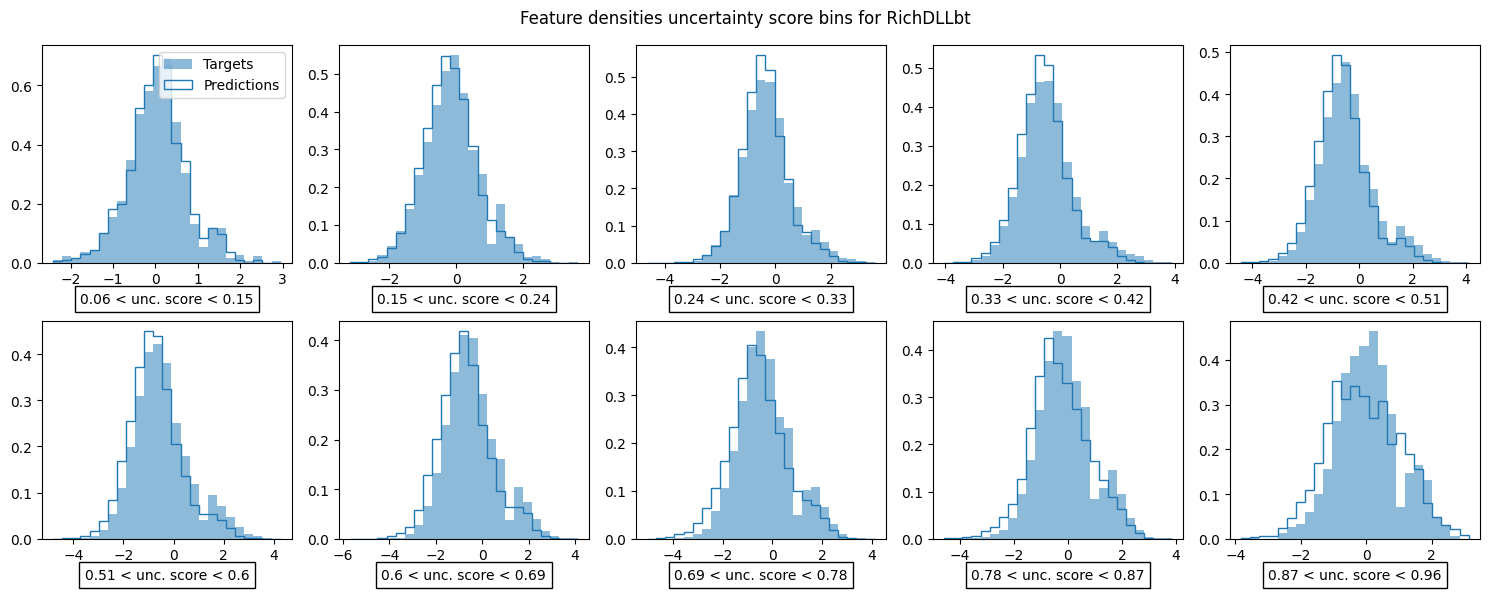

Jensen–Shannon distances:
0.06040523163448578, 0.07589919116588574, 0.07002777858706481, 0.08166735553769508, 0.09368042864455328, 0.11034306663619776, 0.11795724964802236, 0.12255781985675618, 0.11623692429436855, 0.15609814813878692


In [156]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', particle_index = i)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.8804192997158771
Correlation coefficient for RichDLLk: 0.9486277602071876
Correlation coefficient for RichDLLmu: 0.8445661457675884
Correlation coefficient for RichDLLp: 0.82838165315312
Correlation coefficient for RichDLLbt: 0.9658102165777528


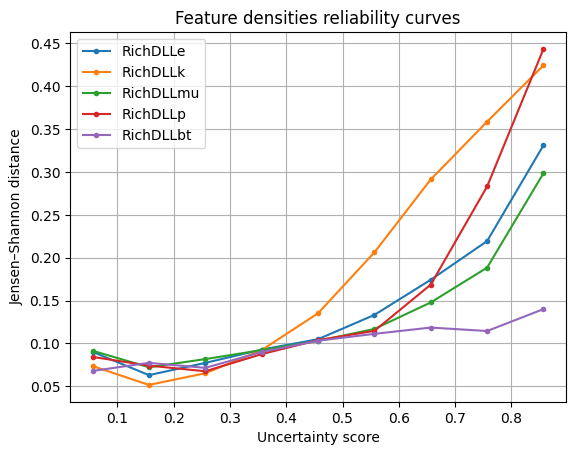

In [34]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')

## Uncertainty heatmaps

In [35]:
def uncertainty_scatter_plot_fd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  plt.title('Feature densities heatmap')
  plt.scatter(momentum, eta, .1, uncertainties, cmap='inferno')
  plt.colorbar(label='Uncertainty score')
  plt.xlabel('Momentum')
  plt.ylabel('Eta')
  plt.show()

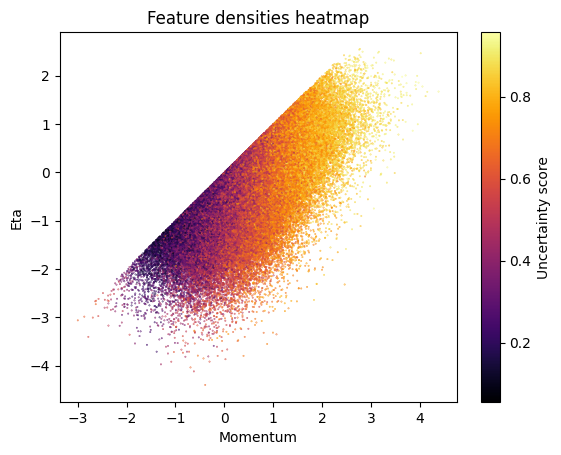

In [36]:
uncertainty_scatter_plot_fd(x_sample, fd_uncertainty_normalized)

In [37]:
def uncertainty_scatter_plot_mcd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  fig, axes = plt.subplots(2, 3, figsize=(11, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    ax.set_title(DLL_COLUMNS[i])
    scatter = ax.scatter(momentum, eta, .1, uncertainties[:, i], cmap='inferno')
    plt.colorbar(scatter, label='Uncertainty score')
    ax.set_xlabel('Momentum')
    ax.set_ylabel('Eta')

  plt.suptitle('MCD heatmaps')
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

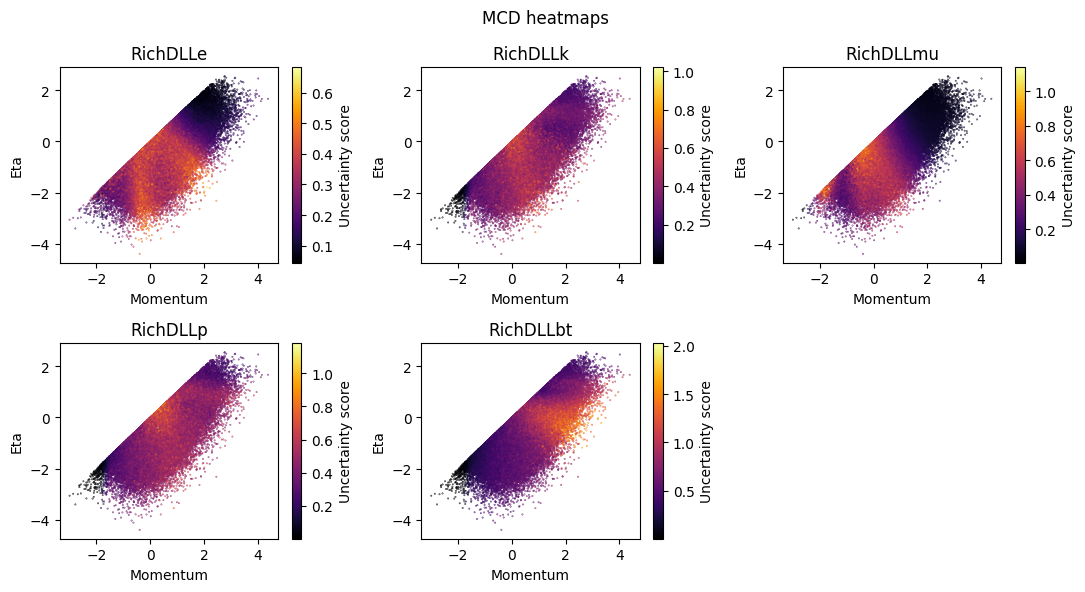

In [38]:
uncertainty_scatter_plot_mcd(x_sample, mcd_uncertainty)

# Efficiency plots

In [39]:
def select_threshold(feature, quantile=0.1):
    return np.quantile(feature, quantile)

def efficiency_bins(targets, threshold, particle_index):
    def compute_efficiency(y):
        return (y > threshold).mean()

    def compute_error(y):
        err = (y < threshold).sum() * (y > threshold).sum() / y.size**3
        return np.sqrt(err)

    efficiencies = []
    errors = []

    for target in targets:
        eff = compute_efficiency(target[:, particle_index])
        err = compute_error(target[:, particle_index])

        efficiencies.append(eff)
        errors.append(err)

    return efficiencies, errors

def compute_bin_indices(data, n_bins):
  bin_edges = np.linspace(data.min(), data.max(), n_bins + 1)
  indices = np.digitize(data, bin_edges)
  return indices

def plot_efficiencies(y_sample, t_generated, uncertainties, quantiles, n_bins=10, dll_columns=DLL_COLUMNS):
  y_sample = np.array(y_sample)
  t_generated = np.array(t_generated)
  uncertainties = np.array(uncertainties)

  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  indices = compute_bin_indices(uncertainties, n_bins)

  bins_targets = [t_generated[indices == i] for i in range(1, n_bins + 1)]
  bins_likelihoods = [uncertainties[indices == i].mean() for i in range(1, n_bins + 1)]

  for idx, ax in zip(range(5), axes.flatten()):
      for quantile in quantiles:
          threshold = select_threshold(y_sample[:, idx], quantile)
          eff, err = efficiency_bins(bins_targets, threshold, idx)

          plot = ax.plot(bins_likelihoods, eff, '.-', label=f'Quantile = {int(quantile * 100)}%')
          ax.errorbar(bins_likelihoods, eff, err, color=plot[0].get_color())

      ax.set_title(dll_columns[idx])
      ax.set_axisbelow(True)
      ax.grid()
      ax.set_xlabel("Bin likelihood")
      ax.set_ylabel("Efficiency")

  axes[-1, -1].axis(False)
  handles, labels = ax.get_legend_handles_labels()
  plt.legend(handles, labels, loc='upper left')

  plt.tight_layout()
  plt.show()

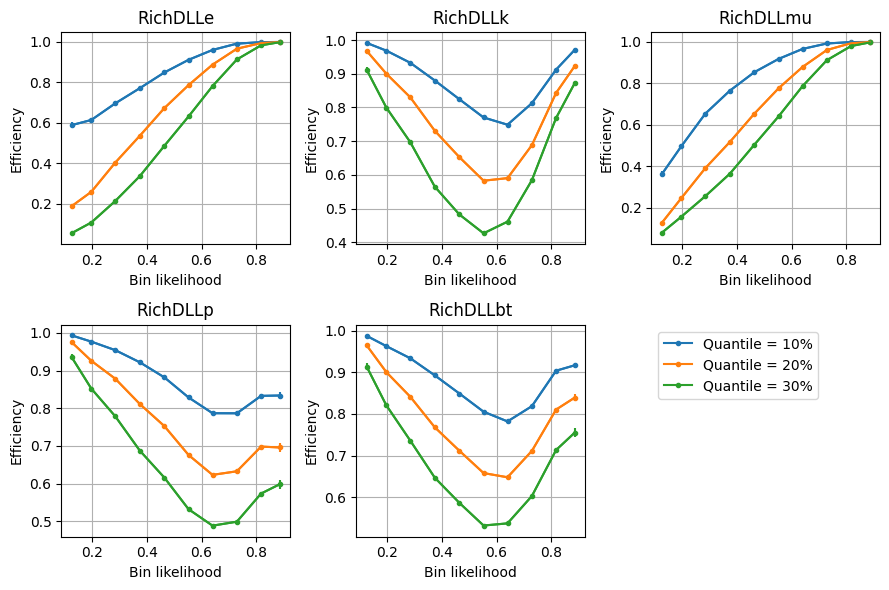

In [40]:
plot_efficiencies(y_sample, t_generated, fd_uncertainty_normalized, [.1, .2, .3])

# Archived

#### FD with integration method


In [43]:
fd_uncertainty_integration, _ = fd_evaluate_model(model, x_sample, known_embeddings=train_embeddings, n_fit_samples=100,
                                                  likelihood_method='integration')

print('Feature Densities using INTEGRATION uncertainty score for x_sample:')
fd_uncertainty_integration

Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 9s 3ms/step
Estimating sample's feature densities


100%|██████████| 100000/100000 [09:40<00:00, 172.17it/s]


Feature Densities using INTEGRATION uncertainty score for x_sample:


<tf.Tensor: shape=(100000,), dtype=float64, numpy=
array([0.99166736, 0.99320438, 0.98483132, ..., 0.98967961, 0.99608143,
       0.99588692])>

In [49]:
# Save FD uncertainties with integration
np.save(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy', fd_uncertainty_integration)

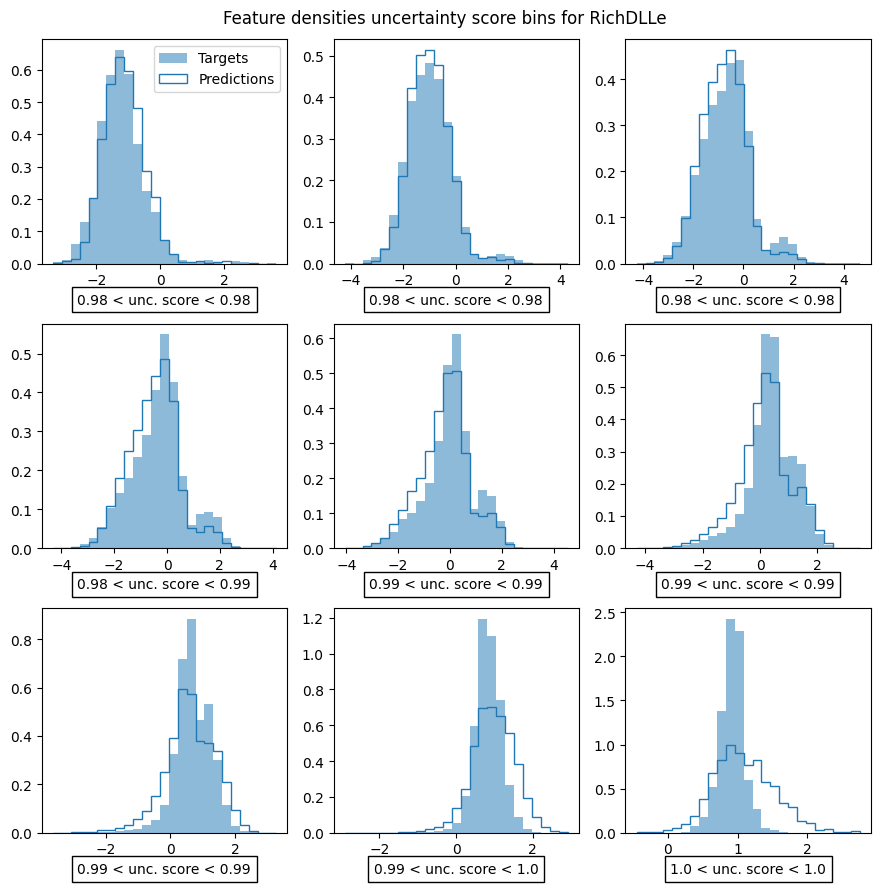

Jensen–Shannon distances:
0.09622084580538806, 0.0585183208196027, 0.07431106037785432, 0.09173176860875591, 0.09969241943001567, 0.1289956595370403, 0.1652380894043553, 0.23538475012621202, 0.37240579948854996


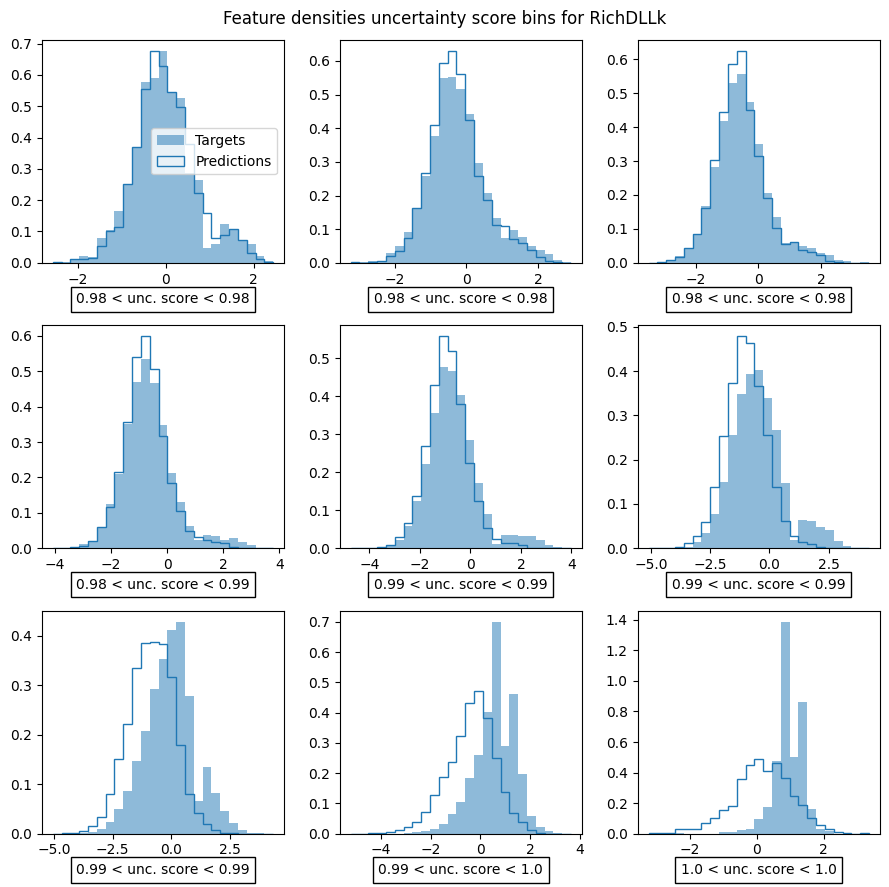

Jensen–Shannon distances:
0.08371077511448784, 0.0654720960520344, 0.05653954859424112, 0.08536574793440575, 0.12179464150396475, 0.19473439847731874, 0.27741588916878446, 0.36904235257402945, 0.4543678655925674


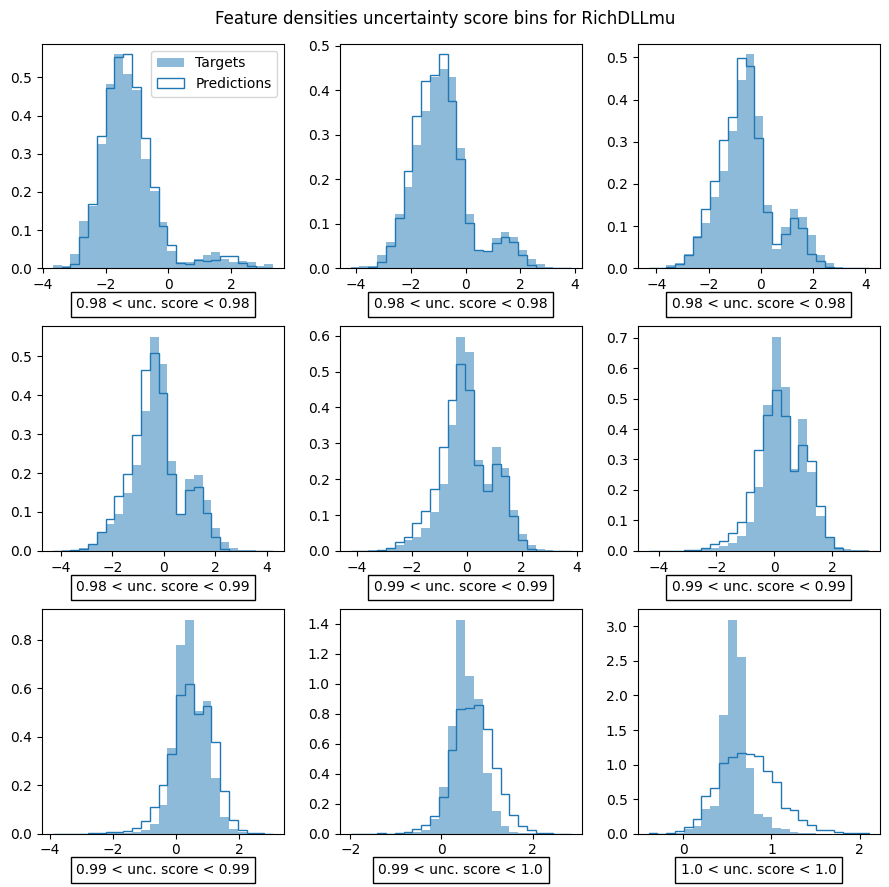

Jensen–Shannon distances:
0.08320841671858444, 0.06635888091019594, 0.08031478887903035, 0.08909623357918102, 0.09709237328152125, 0.11220610235831453, 0.14084113348506, 0.20008794857001014, 0.33758575031583343


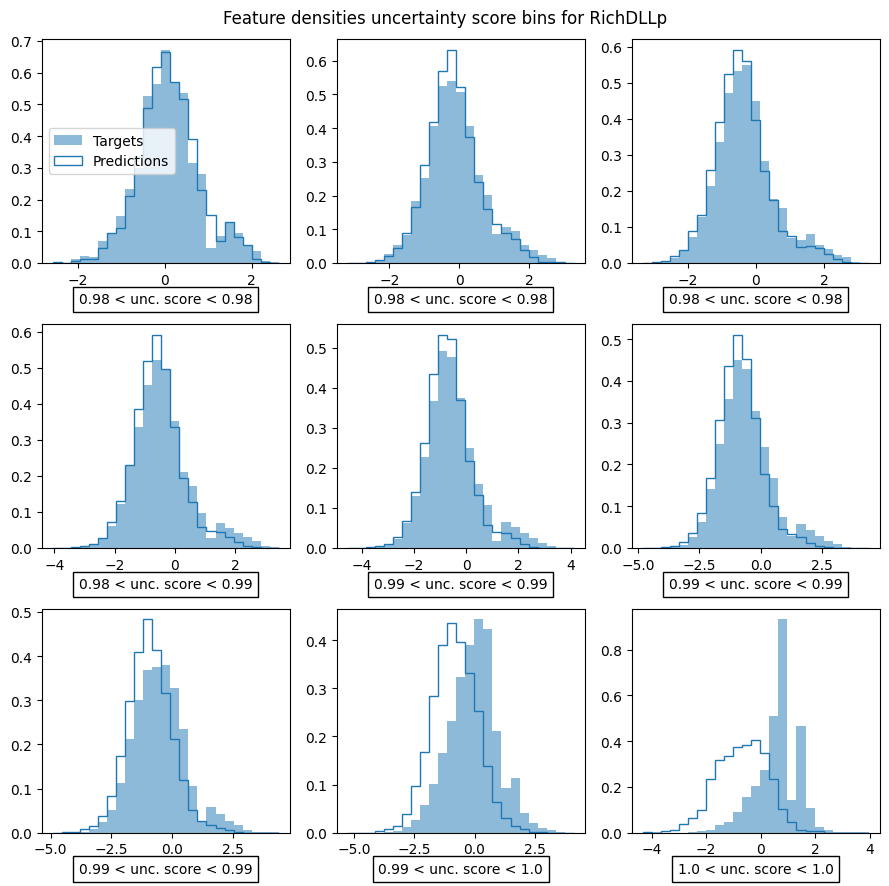

Jensen–Shannon distances:
0.07744682746742482, 0.06820153217264702, 0.07114998976382521, 0.08848384543658083, 0.09976903628186125, 0.1156986940602862, 0.15394968716591595, 0.28277369434794486, 0.49574636685905726


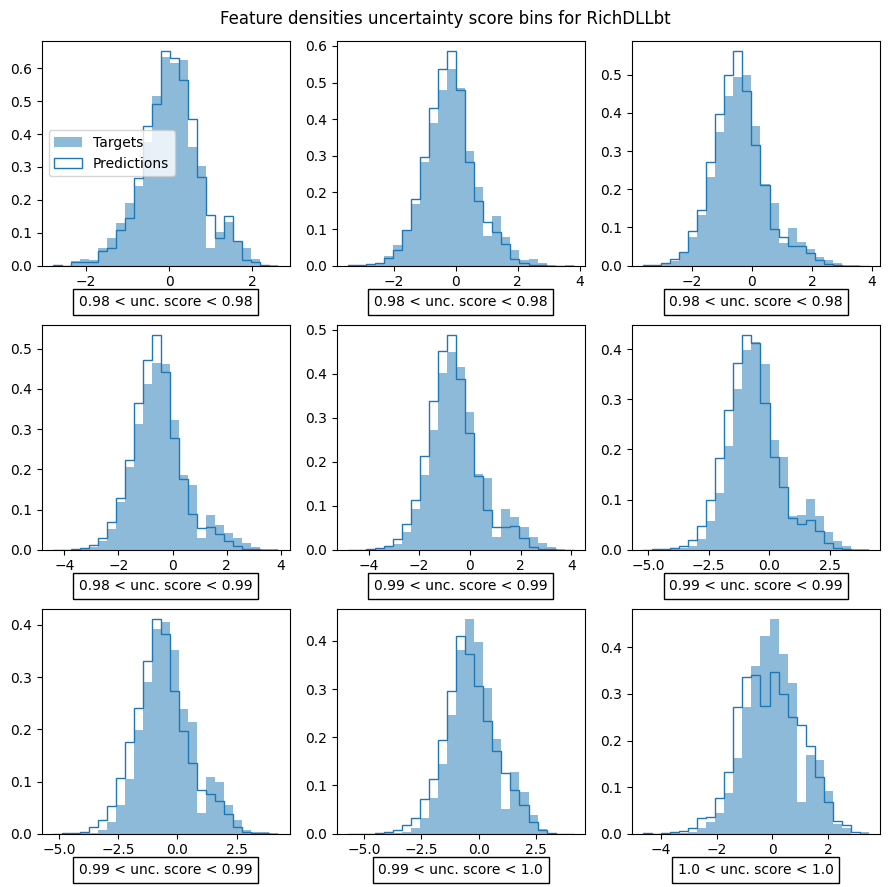

Jensen–Shannon distances:
0.08230790301719008, 0.07236818519397839, 0.07654665836042317, 0.09328260423021431, 0.104209952407771, 0.11565582126353942, 0.12169049182965685, 0.11879987567474574, 0.14639536458260857


In [51]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_integration, 'Feature densities', particle_index = i, n_rows = 3, n_cols = 3)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.845066837334593
Correlation coefficient for RichDLLk: 0.9224163337708419
Correlation coefficient for RichDLLmu: 0.825405229820007
Correlation coefficient for RichDLLp: 0.8058483879419905
Correlation coefficient for RichDLLbt: 0.9469326100625362


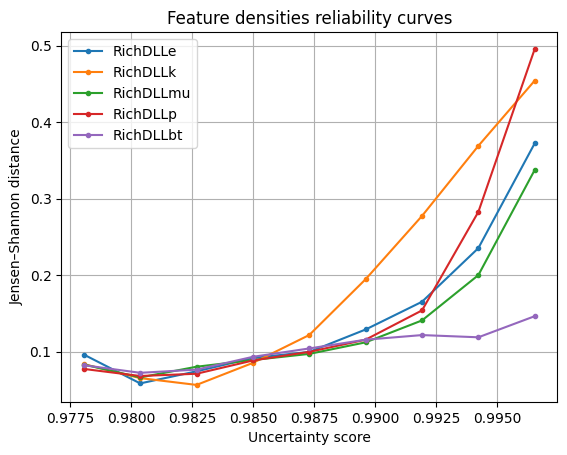

In [52]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')

### Generation of FD embeddings

In [ ]:
# from feature_densities.feature_density_evaluator import create_embeddings_model
# embeddings_model = create_embeddings_model(model)

In [ ]:
# train_embeddings, train_predictions = embeddings_model.predict(dataset['feats_train'])

In [ ]:
# test_embeddings, test_predictions = embeddings_model.predict(dataset['feats_val'])

In [ ]:
# !rm -r embeddings
# !mkdir embeddings

# np.save(embeddings_dir + f'{PARTICLE}_train_embeddings.npy', train_embeddings)
# np.save(embeddings_dir + f'{PARTICLE}_train_predictions.npy', train_predictions)
# np.save(embeddings_dir + f'{PARTICLE}_test_embeddings.npy', test_embeddings)
# np.save(embeddings_dir + f'{PARTICLE}_test_predictions.npy', test_predictions)